**A beta-Poisson model for infectious disease transmission**

This notebook is designed to accompany the upcoming paper of the same title by Joe Hilton and Ian Hall. In the paper, we introduce a branching process model for infectious disease transmission whose offspring distribution is a beta-Poisson mixture distribution. We compare this model's performance as a description of transmission by fitting it to several examples of transmission tree data and comparing these fits to those obtained by the Poisson, geometric, negative binomial, and zero-inflated Poisson (ZIP) models. The code in this notebook includes functions which perform standard probability and likelihood calculations for this model, estimate maximum likelihood parameters, and estimate confidence intervals for these parameters using bootstrapping. We provide a rough outline of the model here, with full derivations left to the paper.

In [1]:
import math
import numpy as np
import scipy as sp
from scipy import special as spsp
from scipy import sparse as sparse
from scipy import stats as stats
from scipy import optimize as opt
from scipy import interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
import mpmath
import matplotlib as mpl
import matplotlib.cm as cm
cmap = cm.hot

**Model description**

The beta-Poisson model describes the person-to-person spread of a pathogen in a population where contact behaviour is homogeneous but transmission behaviour varies from person to person. During their infectious period an infectious individual makes $n$ contacts, drawn from a Poisson distribution with mean $N$. For each case a transmission probability $p$ is chosen from a beta distribution with parameters $(\alpha_1,\alpha_2)$, so that the number of subsequent cases is drawn from a beta-binomial distribution with these parameters and $n$ trials. In our paper we demonstrate that the mean of the resulting distribution is given by
\begin{equation}
\lambda=N\frac{\alpha_1}{\alpha_1+\alpha_2},
\end{equation}
and that if we make the substitution $\Phi=\frac{\alpha_1+\alpha_2}{N}$ the probability mass function can be expressed as:
\begin{equation}
\begin{aligned}
P(x;\lambda,\Phi,N)=\frac{N^x}{\Gamma(x+1)}\frac{\Gamma(x+\Phi \lambda)\Gamma(\Phi N)}{\Gamma(\Phi \lambda)\Gamma(x+\Phi N)}M(x+\Phi \lambda,x+\Phi N,-N).
\end{aligned}
\end{equation}

We demonstrate in the paper that in the limit $N\to\infty$, the beta-Poisson distribution approximates a beta-gamma mixture, i.e. a negative binomial. We will use a slightly unusual parameterisation . The negative binomial with mean $\lambda$ is overdispersed, so that its variance can be expressed as $\lambda(1+\theta)$ for some $\theta>0$. We parameterise the negative binomial in terms of $\lambda$ and $\theta$ so that the pmf is given by
\begin{align}
P(x;\lambda,\theta)=\frac{\Gamma(x+\frac{\lambda}{\theta})}{\Gamma(x+1)\Gamma({\frac{\lambda}{\theta}})}\Bigg(\frac{1}{1+\theta}\Bigg)^{\frac{\lambda}{\theta}}\Bigg(\frac{\theta}{\theta+1}\Bigg)^x.
\end{align}
The negative binomial we obtain in the limit $N\to\infty$ has overdispersion $\theta=\Phi^{-1}$.

In [2]:
def beta_poisson_pmf(x,lmbd,Phi,N):
    if type(x)==int:
        P=spsp.hyp1f1(x+Phi*lmbd,x+Phi*N,-N)
        for n in range(1,x+1): # This loop gives us the N^x/gamma(x+1 term)
            P=(N/n)*P
        for m in range(x): # This loop gives us the term with the two gamma functions in numerator and denominator
            P=((m+Phi*lmbd)/(m+Phi*N))*P
    else:
        P=[]
        for i in range(0,len(x)):
            p=spsp.hyp1f1(x[i]+Phi*lmbd,x[i]+Phi*N,-N)
            for n in range(1,x[i]+1): # This loop gives us the N^x/gamma(x+1 term)
                p=(N/n)*p
            for m in range(x[i]): # This loop gives us the term with the two gamma functions in numerator and denominator
                p=((m+Phi*lmbd)/(m+Phi*N))*p
            P=P+[p]
    return P

The log-likelihood of parameters $(\lambda,\Phi,N)$ given the data $(x_1,...,x_K)$ is given by
\begin{align}
\log\mathcal{L}=\sum\limits_{i=1}^Kx_i\log N-\log\Gamma(x_i+1)+\log\Gamma(\Phi N)+\log\Gamma(x_i+\Phi \lambda)-\log\Gamma(x_i+\Phi N)-\log\Gamma(\Phi \lambda)+\log M(x_i+\Phi \lambda,x_i+\Phi N,-N).
\end{align}
For large values of $N$ this formula is numerically unstable, and in this region we will use the log likelihood function of the negative binomial distribution with $\theta=\Phi^{-1}$. One can justify the choice of $N=1,000$ as a cutoff by calculating the beta-Poisson and negative binomial probability mass functions up to a suitable maximum (x=250 seems a generous upper limit for secondary case data) and for a range of $\lambda$ and $\Phi$ values. In an emerging infection context we are interested in $\lambda$ up to about $2$ and, since $\Phi$ is inversely proportional to the level of overdisperion in the data, considering $\Phi$ values below ten is usually sufficient for fitting overdispersed datasets.

In the next code block, `beta_poisson_loglh` calculates the log likelihood of the beta-Poisson parameters $(\lambda,\Phi,N)$ given a set of count data, and `neg_bin_bp_loglh` the log likelihood of the negative binomial parameters $(\lambda,\Phi^{-1})$, or equivalently the beta-Poisson parameters $(\lambda,\Phi,\infty)$. For the purposes of this notebook it is useful for us to define separate functions calculating the negative binomial log likelihood in the $N\to\infty$ extreme of the beta-Poisson model, and as the likelihood function of the negative binomial model in its own right - hence the "`bp`" in the name of the function in the box immediately below.

In [3]:
def beta_poisson_loglh(data,lmbd,phi,N):
    llh=0
    for x in data:
        llh+=x*np.log(N)-np.real(spsp.loggamma(x+1))+np.real(spsp.loggamma(phi*N))+np.real(spsp.loggamma(x+phi*lmbd))-np.real(spsp.loggamma(x+phi*N))-np.real(spsp.loggamma(phi*lmbd))
        if x+phi*N<50:
            llh+=np.log(spsp.hyp1f1(x+phi*lmbd,x+phi*N,-N))
        else:
            llh+=np.log(float(mpmath.hyp1f1(x+phi*lmbd,x+phi*N,-N)))
    return llh

def neg_bin_bp_loglh(data,lmbd,phi):
    llh=0
    for x in data:
        llh+=np.log(stats.nbinom.pmf(x,lmbd*phi,phi/(phi+1)))
    return llh

Given a vector of count data, we can calculate the maximum likelihood parameters numerically by finding the minimum of the likelihood function. This is a two-dimensional problem, since the MLE of $\lambda$ is just the sample mean. The maximum likelihood estimation is carried out in the function `get_phi_and_N_mles`. Because $N$ can theoretically range up to infinity but its MLE is bounded below by that of $\lambda$, we optimise over $\nu=\frac{1}{N}$ rather than $N$. For values of $\nu$ less than $10^{-3}$ (i.e. values of $N$ greater than $1,000$) the optimiser takes `neg_bin_bp_loglh` as the function to optimise over rather than `beta_poisson_loglh`.

In [4]:
def get_phi_and_N_mles(data,phi_0,N_0):
    def f(params):
        lmbd=np.mean(data)
        phi=params[0]
        if params[1]>0.1e-3:
            N=1/params[1]
            return -beta_poisson_loglh(data,lmbd,phi,N)
        else:
            return -neg_bin_bp_loglh(data,lmbd,phi)
    mle=sp.optimize.minimize(f,[phi_0,N_0],bounds=((1e-6,50),(0,1/np.mean(data))))
    if mle.x[1]<0:
        mle.x[1]=0
    return mle.x[0],mle.x[1]

In the supplementary material to the paper we show that the pgf of a beta-Poisson distributed random variable $X$ is
\begin{equation}
    G_X(s)=M(\lambda\Phi,N\Phi,N(s-1)).
\end{equation}
This is calculated using the function `beta_poisson_pgf`. From standard branching process theory, the extinction probability of a beta-Poisson epidemic is the solution to the equation
\begin{equation}
    q=G(q),
\end{equation}
and can be calculated using the function `beta_poisson_extinction_prob`.

These functions are not used to calculate any of the results presented in our paper, but are included here for completeness.

In [5]:
def beta_poisson_pgf(s,lmbd,phi,N):
    if np.size(np.asarray(s))==1:
        G=spsp.hyp1f1(lmbd*phi,N*phi,N*(s-1));
    else:
        G=[]
        for i in range(0,np.size(np.asarray(s))):
            G=G+[spsp.hyp1f1(lmbd*phi,N*phi,N*(s[i]-1))]
    return G

def beta_poisson_extinction_prob( lmbd,phi,N ):
    if lmbd<=1:
        return 1
    else:
        def f(s):
            return beta_poisson_pgf(s,lmbd,phi,N)-s
        q=opt.brentq(
            f, 0, 1-1e-4);
        return q

The functions in the following block carry out the equivalent calculations (log likelihood, maximum likelihood estimates, pgf, and extinction probability) for the Poisson, geometric, negative binomial, and ZIP calculations.


The function `nbinom.pmf` in the `scipy.stats` package uses a parameterisation in terms of parameters $n$ and $p$. Under this parameterisation the mean and variance of the distribution are respectively given by $(1-p)n/p$ and $(1-p)n/p^2$. After some rearrangement, one can show that $n=\lambda/\theta$ and $p=1/(\theta+1)$, so that to calculate negative binomial probabilities (and likelihoods) in our $(\lambda,\theta)$ parameterisation we use `stats.nbinom.pmf(x,lmbd/theta,1/(theta+1))`.

In [6]:
def poisson_loglh(data,lmbd):
    llh=0
    for x in data:
        llh+=np.log(stats.poisson.pmf(x,lmbd))
    return llh
        
def geo_loglh(data,lmbd):
    llh=0
    for x in data:
        llh+=np.log(stats.geom.pmf(x,1/(lmbd+1),-1))
    return llh

def neg_bin_loglh(data,lmbd,theta):
    llh=0
    for x in data:
        llh+=np.log(stats.nbinom.pmf(x,lmbd/theta,1/(theta+1)))
    return llh

def get_theta_mle(data,theta_0):
    def f(theta):
        lmbd=np.mean(data)
        return -neg_bin_loglh(data,lmbd,theta)
    mle=sp.optimize.minimize(f,[theta_0],bounds=((1e-6,50),))
    return mle.x[0]

def zip_pmf(x,lmbd,sigma):
    if type(x)==int:
        return sigma*(x==0)+(1-sigma)*stats.poisson.pmf(x,lmbd)
    else:
        return sigma*np.equal(x,np.zeros(len(x)))+(1-sigma)*stats.poisson.pmf(x,lmbd)

def zip_loglh(data,lmbd,sigma):
    llh=0
    for x in data:
        if x==0:
            llh+=np.log(sigma+(1-sigma)*np.exp(-lmbd))
        else:
            llh+=np.log(1-sigma)+np.log(stats.poisson.pmf(x,lmbd))
    return llh

def get_zip_mles(data,lmbd_0,sigma_0):
    def f(params):
        lmbd=params[0]
        sigma=params[1]
        return -zip_loglh(data,lmbd,sigma)
    mle=sp.optimize.minimize(f,[lmbd_0,sigma_0],bounds=((np.mean(data),50),(0,1-1e-6)))
    return mle.x[0],mle.x[1]

**Fits to transmission chain data**

In our paper we study the fitting behaviour of the beta-Poisson model by fitting it (and our other models of interest) to eight transmission chain datasets. We estimate maximum likelihood parameters and calculate the Akaike Information Criterion (AIC) for each fitted model.

**Plague**<br/>
From [Gani and Leach 2004](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3323083/pdf/03-0509.pdf).

To begin with, we calculate the maximum likelihood parameters and associated AIC for each model:

In [7]:
current_data=[0]*16+[1]*10+[2]*7+[3]*2+[4]*3+[5]+[6]

theta_mle=get_theta_mle(current_data,1.5)
phi_mle,N_inv_mle=get_phi_and_N_mles(current_data,0.5,1/2)
lmbd_mle,sigma_mle=get_zip_mles(current_data,1.5,0.5)

np.set_printoptions(precision=3)
print('Distribution          | Lambda | Theta | Sigma |Nu=1/N |  Phi  | Log Likelihood |   AIC  |')
print('__________________________________________________________________________________________')
print('Poisson               |',np.mean(current_data),' |       |       |       |       |   ',"%.3f"% poisson_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*poisson_loglh(current_data,np.mean(current_data))))
print('Geometric             |',np.mean(current_data),' |       |       |       |       |   ',"%.3f"% geo_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*geo_loglh(current_data,np.mean(current_data))))
print('Negative binomial     |',np.mean(current_data),' |',"%.3f"% theta_mle,'|       |       |       |   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),theta_mle),'    |',"%.3f"% (4-2*neg_bin_loglh(current_data,np.mean(current_data),theta_mle)))
print('Zero-inflated Poisson |',"%.3f"% lmbd_mle,' |       |',"%.3f"% sigma_mle,'|       |       |   ',"%.3f"% zip_loglh(current_data,lmbd_mle,sigma_mle),'    |',"%.3f"% (4-2*zip_loglh(current_data,lmbd_mle,sigma_mle)))
print('Beta Poisson          |',np.mean(current_data),' |       |       |',np.around(N_inv_mle,decimals=3),'|',"%.3f"% phi_mle,'|   ',"%.3f"% beta_poisson_loglh(current_data,np.mean(current_data),phi_mle,1/N_inv_mle),'    |',"%.3f"% (6-2*beta_poisson_loglh(current_data,np.mean(current_data),phi_mle,1/N_inv_mle)))

Distribution          | Lambda | Theta | Sigma |Nu=1/N |  Phi  | Log Likelihood |   AIC  |
__________________________________________________________________________________________
Poisson               | 1.325  |       |       |       |       |    -67.422     | 136.843
Geometric             | 1.325  |       |       |       |       |    -63.551     | 129.102
Negative binomial     | 1.325  | 0.923 |       |       |       |    -63.312     | 130.624
Zero-inflated Poisson | 1.867  |       | 0.290 |       |       |    -63.945     | 131.890
Beta Poisson          | 1.325  |       |       | 0.248 | 0.583 |    -63.120     | 132.240


Plotting the data and fitted models demonstrates that the Poisson fails to capture the high incidence of zeros in the data:

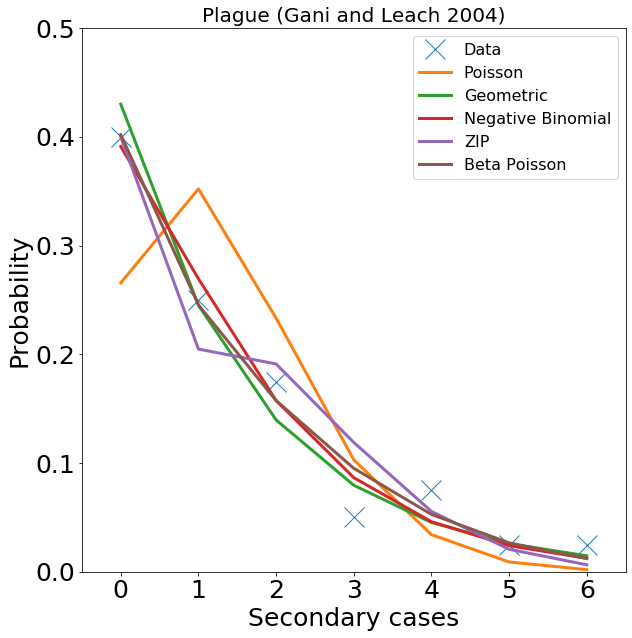

In [8]:
fig, ax=plt.subplots(figsize=(10,10))

xVals=range(max(current_data)+1)

counts,bins=np.histogram(current_data,7)
dist=counts/len(current_data)
ax.plot(np.where(dist>0)[0],dist[dist>0],'x',markersize=20)
PoiLine=stats.poisson.pmf(xVals,np.mean(current_data))
ax.plot(xVals,PoiLine,lw=3)
GeomLine=stats.geom.pmf(xVals,1/(np.mean(current_data)+1),-1)
ax.plot(xVals,GeomLine,lw=3)
NegBinLine=stats.nbinom.pmf(xVals,np.mean(current_data)/theta_mle,1/(theta_mle+1))
ax.plot(xVals,NegBinLine,lw=3)
ZIPLine=zip_pmf(xVals,lmbd_mle,sigma_mle)
ax.plot(xVals,ZIPLine,lw=3)
BetaPoiLine=beta_poisson_pmf(xVals,np.mean(current_data),phi_mle,1/N_inv_mle)
ax.plot(xVals,BetaPoiLine,lw=3)
ax.axis([-0.5,6.5,0,0.5])
ax.set_aspect(7/0.5)

ax.legend(['Data','Poisson','Geometric','Negative Binomial','ZIP','Beta Poisson'],fontsize=16)
plt.xlabel('Secondary cases',fontsize=25)
plt.ylabel('Probability',fontsize=25)
plt.title('Plague (Gani and Leach 2004)',fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

We can also visualise the distribution of infectivity across cases in the fitted beta-Poisson by plotting the underlying beta distribution:

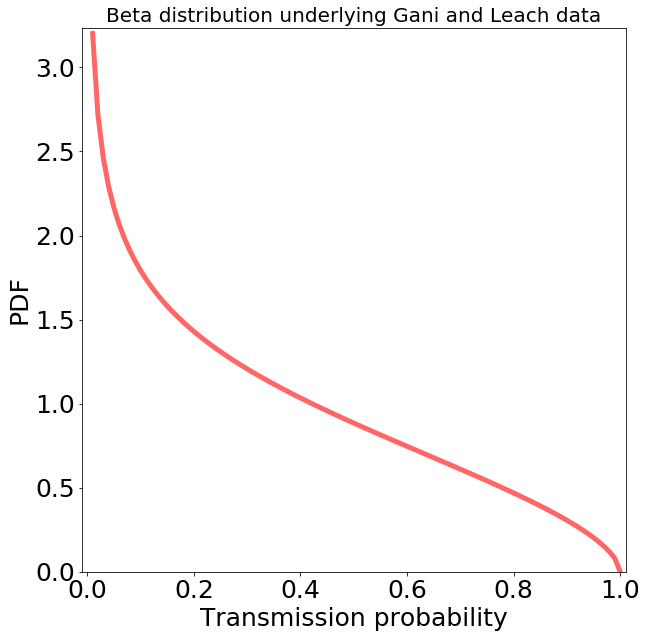

In [9]:
x = np.linspace(1e-2,1, 100)
y=stats.beta.pdf(x, np.mean(current_data)*phi_mle, (1/N_inv_mle-np.mean(current_data))*phi_mle)
fig,ax=plt.subplots(figsize=(10,10))
plt.plot(x, y,'r-', lw=5, alpha=0.6, label='beta pdf')
ax.axis([-0.01,1.01,0,1.01*np.max(y)])
ax.set_aspect(1.02/(1.01*np.max(y)))
plt.xlabel('Transmission probability',fontsize=25)
plt.ylabel('PDF',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Beta distribution underlying Gani and Leach data',fontsize=20)
plt.show()

The fitting behaviour of the beta-Poisson model can be visualised by calculating thelikelihood function of each parameter with the other two fixed at their MLEs. The slow decay of the likelihood function associated with increasing values of $\Phi$ is consistent with the relatively high likelihood assigned to the Poisson distribution, which means that models with very low levels of overdispersion (i.e. large values of $\Phi$) can give a good fit.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


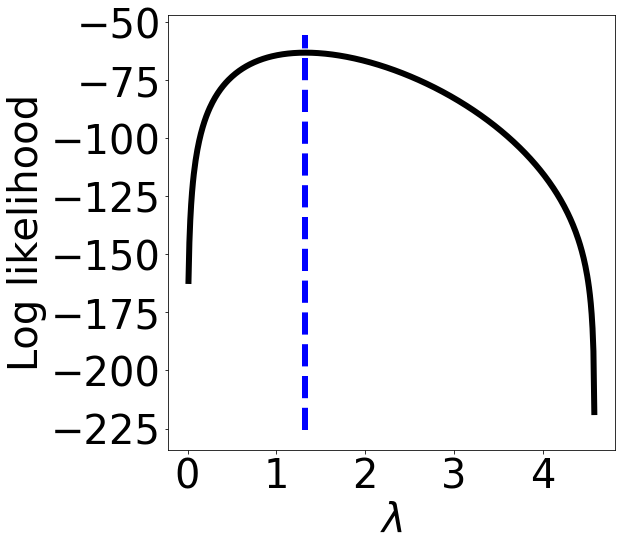

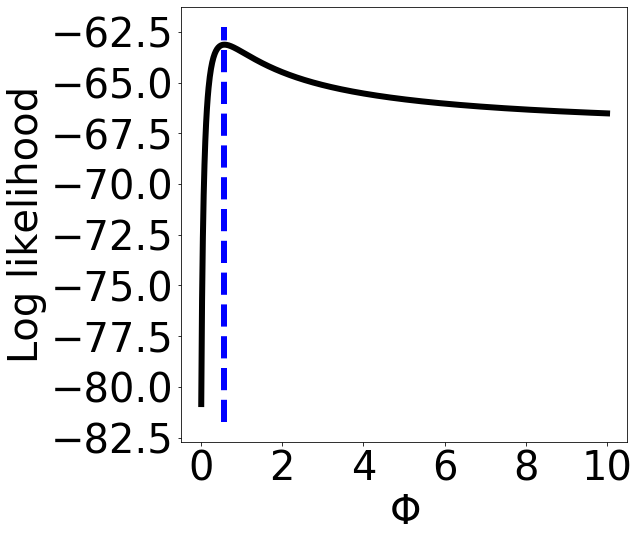

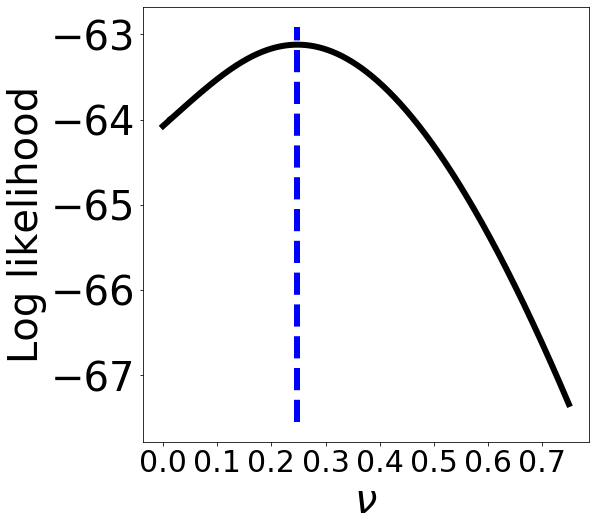

In [10]:
true_lmbd,true_phi,true_N=np.mean(current_data),phi_mle,1/N_inv_mle
data=current_data
lmbd_lh_array=beta_poisson_loglh(data,np.linspace(0.01,5,500),true_phi,true_N)
phi_lh_array=np.zeros(1000)
for i in range(1000):
    phi_lh_array[i]=beta_poisson_loglh(data,true_lmbd,(i+1)*1e-2,true_N)
n_lh_array=np.zeros(750)
n_lh_array[0]=neg_bin_bp_loglh(data,true_lmbd,true_phi)
for i in range(1,750):
    n_lh_array[i]=beta_poisson_loglh(data,true_lmbd,true_phi,1/(i/1000))

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(np.linspace(0.01,5,500),lmbd_lh_array,'k',linewidth=6)
ax.plot([true_lmbd,true_lmbd],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\lambda$',fontsize=40)
plt.ylabel('Log likelihood',fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.show()

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(np.linspace(0.01,10,1000),phi_lh_array,'k',linewidth=6)
ax.plot([true_phi,true_phi],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\Phi$',fontsize=40)
plt.ylabel('Log likelihood',fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.show()

fig,ax=plt.subplots(figsize=(8,8))
ax.plot(np.linspace(0.0,0.749,750),n_lh_array,'k',linewidth=6)
ax.plot([1/true_N,1/true_N],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\\nu$',fontsize=40)
plt.ylabel('Log likelihood',fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)
plt.show()

**Monkeypox**

From [Jezek *et al.* 1987](https://academic.oup.com/aje/article-abstract/126/6/1082/81684).

This paper includes information about social contact behaviour in the population where the outbreak took place, from which we can estimate that the average number of contacts made during one infectious period is 10.66. We can use this estimate in parameterising the beta-Poisson model, so that rather than fitting $N$ using MLE we just set $N=10.66$. The function `get_lambda_and_phi_mles` estimates the maximum likelihood values of $\lambda$ and $\Phi$ with an empirically measured $N$:

In [11]:
def get_lambda_and_phi_mles(data,lmbd_0,phi_0,N_emp):
    def f(params):
        lmbd=params[0]
        phi=params[1]
        return -beta_poisson_loglh(data,lmbd,phi,N_emp)
    mle=sp.optimize.minimize(f,[lmbd_0,phi_0],bounds=((1e-6,10),(1e-6,50)))
    return mle.x[0],mle.x[1]

The transmission chain data given in the paper is stratified by generation. In this notebook we aggregate the generations into a single set of secondary case counts, but one could perform fits for each generation to see how parameters change during the outbreak. When we do not use the empirical estimate of $N$, the beta-Poisson model fits to its negative binomial extreme.

In [12]:
jezek_data_g1=[0]*114+[1]*23+[2]*8+[3]*1+[5]*1 # First generation cases
jezek_data_g2=[0]*38+[1]*7+[2]*1+[3]*1 # Second generation cases
jezek_data_g3=[0]*9+[1]+[2]
jezek_data_g4=[0]*2+[1]
current_data=jezek_data_g1+jezek_data_g2+jezek_data_g3+jezek_data_g4

jezek_contact_data=[3]*14+[7]*40+[12]*23+[17]*14+[24]*7+[31]*2
empirical_N=np.mean(jezek_contact_data)

theta_mle=get_theta_mle(current_data,1.5)
phi_mle,N_inv_mle=get_phi_and_N_mles(current_data,0.5,1/2)
lmbd_mle,sigma_mle=get_zip_mles(current_data,1.5,0.5)
lmbd_emp_mle,phi_emp_mle=get_lambda_and_phi_mles(current_data,0.5,0.5,empirical_N)

np.set_printoptions(precision=3)
print('Distribution          | Lambda | Theta | Sigma | Nu=1/N |  Phi  | Log Likelihood |   AIC  |')
print('__________________________________________________________________________________________')
print('Poisson               |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% poisson_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*poisson_loglh(current_data,np.mean(current_data))))
print('Geometric             |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% geo_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*geo_loglh(current_data,np.mean(current_data))))
print('Negative binomial     |',"%.3f"% np.mean(current_data),' |',"%.3f"% theta_mle,'|       |         |       |   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),theta_mle),'    |',"%.3f"% (4-2*neg_bin_loglh(current_data,np.mean(current_data),theta_mle)))
print('Zero-inflated Poisson |',"%.3f"% lmbd_mle,' |       |',"%.3f"% sigma_mle,'|         |       |   ',"%.3f"% zip_loglh(current_data,lmbd_mle,sigma_mle),'    |',"%.3f"% (4-2*zip_loglh(current_data,lmbd_mle,sigma_mle)))
print('Beta Poisson          |',"%.3f"% np.mean(current_data),' |       |       |',np.around(N_inv_mle,decimals=3),'    |',"%.3f"% phi_mle,'|   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),1/phi_mle),'    |',"%.3f"% (6-2*neg_bin_loglh(current_data,np.mean(current_data),1/phi_mle)))
print('Empirical b-P         |',"%.3f"% lmbd_emp_mle,' |       |       |',"%.3f"% empirical_N,' |',"%.3f"% phi_emp_mle,'|   ',"%.3f"% beta_poisson_loglh(current_data,lmbd_emp_mle,phi_emp_mle,empirical_N),'    |',"%.3f"% (6-2*beta_poisson_loglh(current_data,lmbd_emp_mle,phi_emp_mle,empirical_N)))

Distribution          | Lambda | Theta | Sigma | Nu=1/N |  Phi  | Log Likelihood |   AIC  |
__________________________________________________________________________________________
Poisson               | 0.303  |       |       |         |       |    -153.550     | 309.100
Geometric             | 0.303  |       |       |         |       |    -146.949     | 295.898
Negative binomial     | 0.303  | 0.518 |       |         |       |    -146.317     | 296.634
Zero-inflated Poisson | 0.715  |       | 0.577 |         |       |    -147.010     | 298.020
Beta Poisson          | 0.303  |       |       | 0.0     | 1.931 |    -146.317     | 298.634
Empirical b-P         | 0.303  |       |       | 10.660  | 1.810 |    -146.323     | 298.646


When we plot the fitted distributions, the negative binomial and beta-Poisson (without the empirically measured value of $N$) are identical because the beta-Poisson has fitted to its negative binomial extreme:

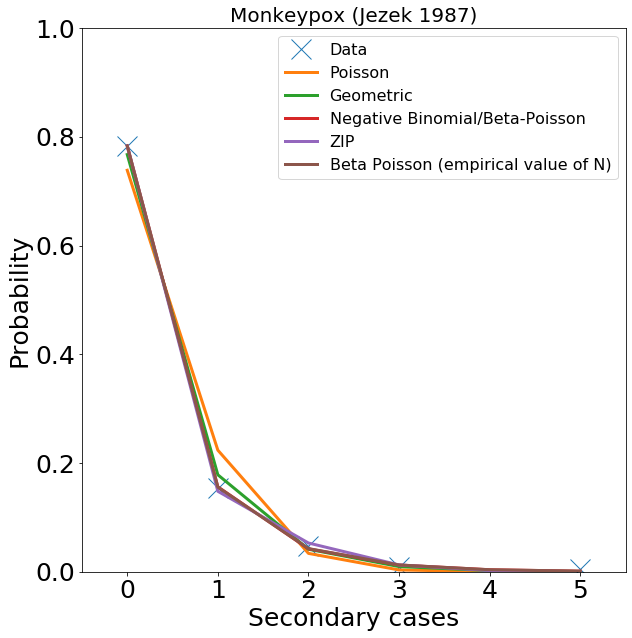

In [13]:
fig, ax=plt.subplots(figsize=(10,10))

xVals=range(max(current_data)+1)

counts,bins=np.histogram(current_data,np.max(current_data)+1)
dist=counts/len(current_data)
ax.plot(np.where(dist>0)[0],dist[dist>0],'x',markersize=20)
PoiLine=stats.poisson.pmf(xVals,np.mean(current_data))
ax.plot(xVals,PoiLine,lw=3)
GeomLine=stats.geom.pmf(xVals,1/(np.mean(current_data)+1),-1)
ax.plot(xVals,GeomLine,lw=3)
NegBinLine=stats.nbinom.pmf(xVals,np.mean(current_data)/theta_mle,1/(theta_mle+1))
ax.plot(xVals,NegBinLine,lw=3)
ZIPLine=zip_pmf(xVals,lmbd_mle,sigma_mle)
ax.plot(xVals,ZIPLine,lw=3)
BetaPoiLine=beta_poisson_pmf(xVals,lmbd_emp_mle,phi_emp_mle,empirical_N)
ax.plot(xVals,BetaPoiLine,lw=3)
ax.axis([-0.5,np.max(current_data)+0.5,0,1])
ax.set_aspect((np.max(current_data)+1)/1)

ax.legend(['Data','Poisson','Geometric','Negative Binomial/Beta-Poisson','ZIP','Beta Poisson (empirical value of N)'],fontsize=16)
plt.xlabel('Secondary cases',fontsize=25)
plt.ylabel('Probability',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Monkeypox (Jezek 1987)',fontsize=20)
plt.show()

When the beta-Poisson fits to its negative binomial extreme, we get a gamma distribution for the individual level reproductive ratio rather than a beta distribution for the infection probability:

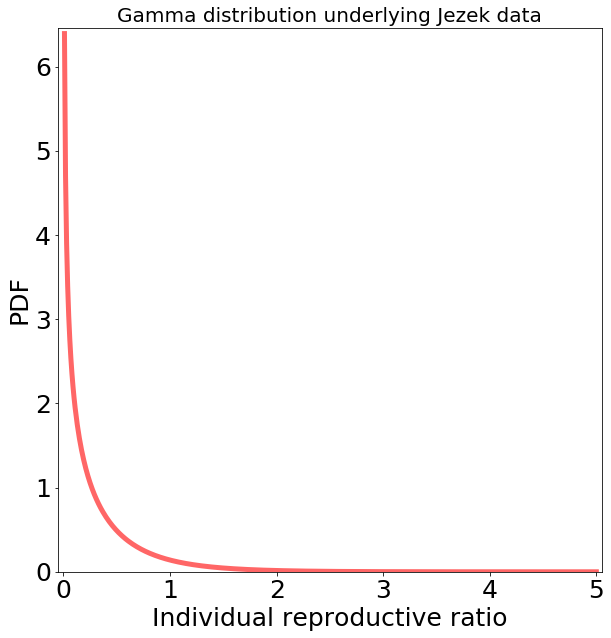

In [14]:
x = np.linspace(1e-2,5, 500)
y=stats.gamma.pdf(x, np.mean(current_data)/theta_mle, loc=0, scale=theta_mle)
fig,ax=plt.subplots(figsize=(10,10))
plt.plot(x, y,'r-', lw=5, alpha=0.6, label='beta pdf')
ax.axis([-0.05,5.05,0,1.01*np.max(y)])
ax.set_aspect(5.1/(1.01*np.max(y)))
plt.xlabel('Individual reproductive ratio',fontsize=25)
plt.ylabel('PDF',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Gamma distribution underlying Jezek data',fontsize=20)
plt.show()

When $\lambda$ and $\Phi$ are fitted using the empirically estimated $N$, we obtain a distribution of transmission probability with most individuals unlikely to spread infection:

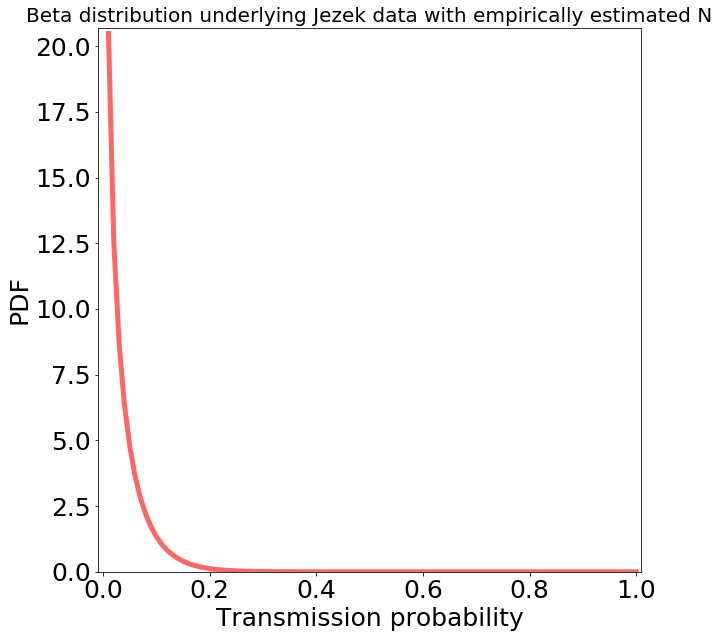

In [15]:
x = np.linspace(1e-2,1, 100)
y=stats.beta.pdf(x, lmbd_emp_mle*phi_emp_mle, (empirical_N-lmbd_emp_mle)*phi_emp_mle)
fig,ax=plt.subplots(figsize=(10,10))
plt.plot(x, y,'r-', lw=5, alpha=0.6, label='beta pdf')
ax.axis([-0.01,1.01,0,1.01*np.max(y)])
ax.set_aspect(1.02/(1.01*np.max(y)))
plt.xlabel('Transmission probability',fontsize=25)
plt.ylabel('PDF',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Beta distribution underlying Jezek data with empirically estimated N',fontsize=20)
plt.show()

In the following box we visualise the sensitivity of the fits using the empirically estimated $N$:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


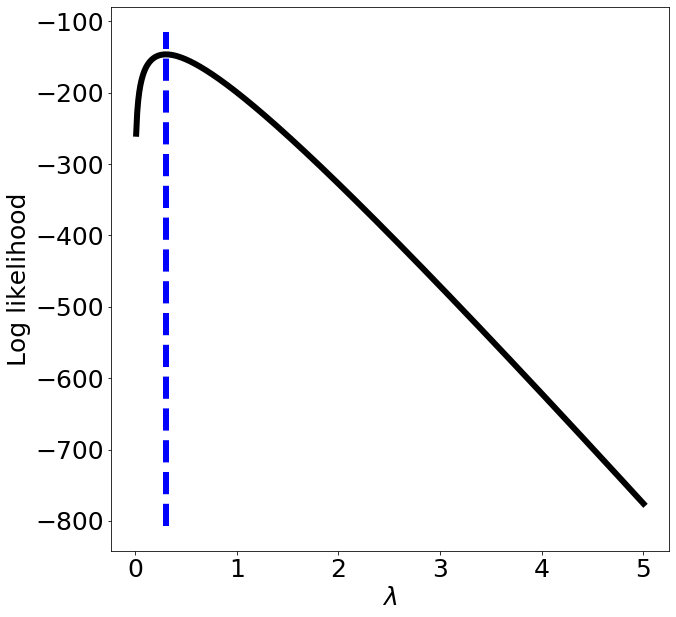

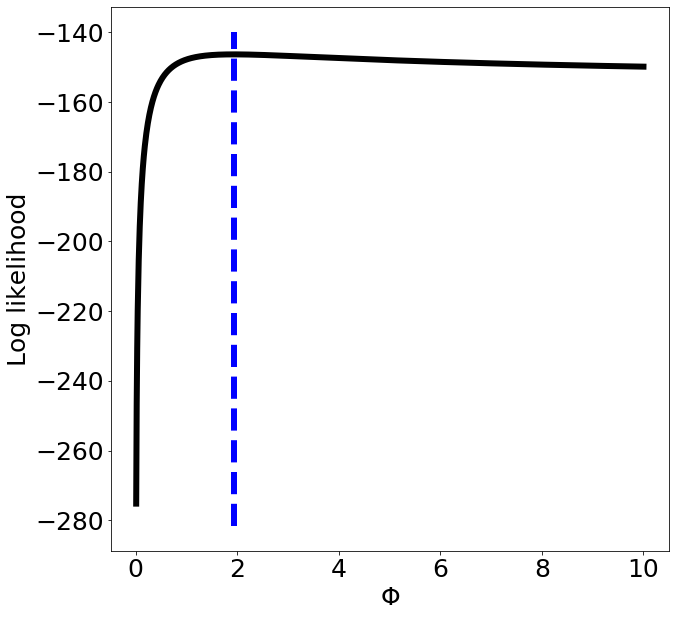

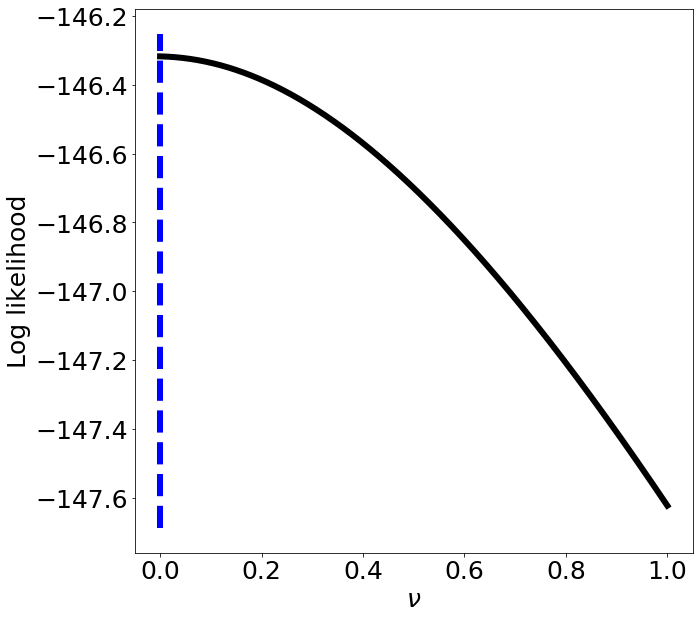

In [16]:
true_lmbd,true_phi,true_N=np.mean(current_data),phi_mle,1/N_inv_mle
data=current_data
lmbd_lh_array=neg_bin_bp_loglh(data,np.linspace(0.01,5,500),true_phi)
phi_lh_array=np.zeros(1000)
for i in range(1000):
    phi_lh_array[i]=neg_bin_bp_loglh(data,true_lmbd,(i+1)*1e-2)
n_lh_array=np.zeros(1001)
n_lh_array[0]=neg_bin_bp_loglh(data,true_lmbd,true_phi)
for i in range(1,1001):
    n_lh_array[i]=beta_poisson_loglh(data,true_lmbd,true_phi,1/(i/1000))

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,5,500),lmbd_lh_array,'k',linewidth=6)
ax.plot([true_lmbd,true_lmbd],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,10,1000),phi_lh_array,'k',linewidth=6)
ax.plot([true_phi,true_phi],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\Phi$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.0,1,1001),n_lh_array,'k',linewidth=6)
ax.plot([1/true_N,1/true_N],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\\nu$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In this box we visualise the fits when the empirical $N$ is used:

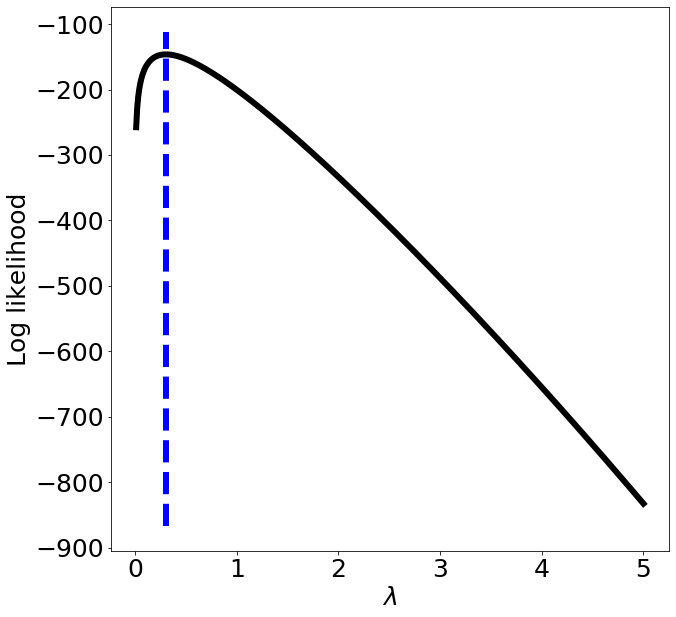

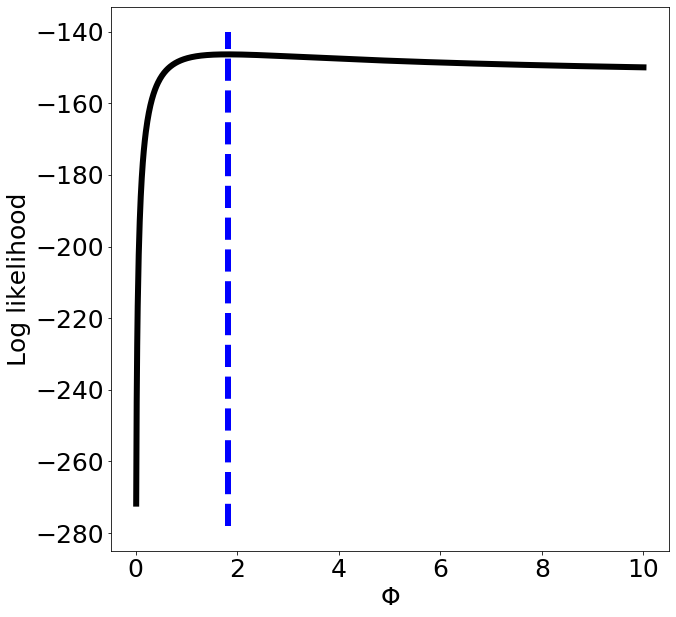

In [17]:
true_lmbd,true_phi,true_N=lmbd_emp_mle,phi_emp_mle,empirical_N
data=current_data
lmbd_lh_array=beta_poisson_loglh(data,np.linspace(0.01,5,500),true_phi,true_N)
phi_lh_array=np.zeros(1000)
for i in range(1000):
    phi_lh_array[i]=beta_poisson_loglh(data,true_lmbd,(i+1)*1e-2,true_N)

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,5,500),lmbd_lh_array,'k',linewidth=6)
ax.plot([true_lmbd,true_lmbd],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,10,1000),phi_lh_array,'k',linewidth=6)
ax.plot([true_phi,true_phi],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\Phi$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

** Ebola in Guinea**

Originally reported in [Faye et al. 2015](https://www.sciencedirect.com/science/article/pii/S1473309914710758#bib2).
Numbers used here can be found in the supplementary material of [Althaus 2015][1].

[1]: https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(15)70135-0/fulltext

In [18]:
current_data=[1,2,2,5,14,1,4,4,1,3,3,8,2,1,1,4,9,9,1,1,17,2,1,1,1,4,3,3,4,2,5,1,2,2,1,9,1,3,1,2,1,1,2]
current_data=current_data+[0]*(152-len(current_data))

theta_mle=get_theta_mle(current_data,1.5)
phi_mle,N_inv_mle=get_phi_and_N_mles(current_data,0.5,1/50)
lmbd_mle,sigma_mle=get_zip_mles(current_data,1.5,0.5)

np.set_printoptions(precision=3)
print('Distribution          | Lambda | Theta | Sigma | Nu=1/N  |  Phi  | Log Likelihood  |   AIC  |')
print('__________________________________________________________________________________________')
print('Poisson               |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% poisson_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*poisson_loglh(current_data,np.mean(current_data))))
print('Geometric             |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% geo_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*geo_loglh(current_data,np.mean(current_data))))
print('Negative binomial     |',"%.3f"% np.mean(current_data),' |',"%.3f"% theta_mle,'|       |         |       |   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),theta_mle),'    |',"%.3f"% (4-2*neg_bin_loglh(current_data,np.mean(current_data),theta_mle)))
print('Zero-inflated Poisson |',"%.3f"% lmbd_mle,' |       |',"%.3f"% sigma_mle,'|         |       |   ',"%.3f"% zip_loglh(current_data,lmbd_mle,sigma_mle),'    |',"%.3f"% (4-2*zip_loglh(current_data,lmbd_mle,sigma_mle)))
print('Beta Poisson          |',"%.3f"% np.mean(current_data),' |       |       | ',np.around(N_inv_mle,decimals=3),' |',"%.3f"% phi_mle,'|   ',"%.3f"% beta_poisson_loglh(current_data,np.mean(current_data),phi_mle,1/N_inv_mle),'    |',"%.3f"% (6-2*beta_poisson_loglh(current_data,np.mean(current_data),phi_mle,1/N_inv_mle)))

Distribution          | Lambda | Theta | Sigma | Nu=1/N  |  Phi  | Log Likelihood  |   AIC  |
__________________________________________________________________________________________
Poisson               | 0.954  |       |       |         |       |    -300.205     | 602.410
Geometric             | 0.954  |       |       |         |       |    -205.782     | 413.564
Negative binomial     | 0.954  | 5.256 |       |         |       |    -177.197     | 358.393
Zero-inflated Poisson | 3.240  |       | 0.706 |         |       |    -206.054     | 416.108
Beta Poisson          | 0.954  |       |       |  0.014  | 0.183 |    -177.183     | 360.366


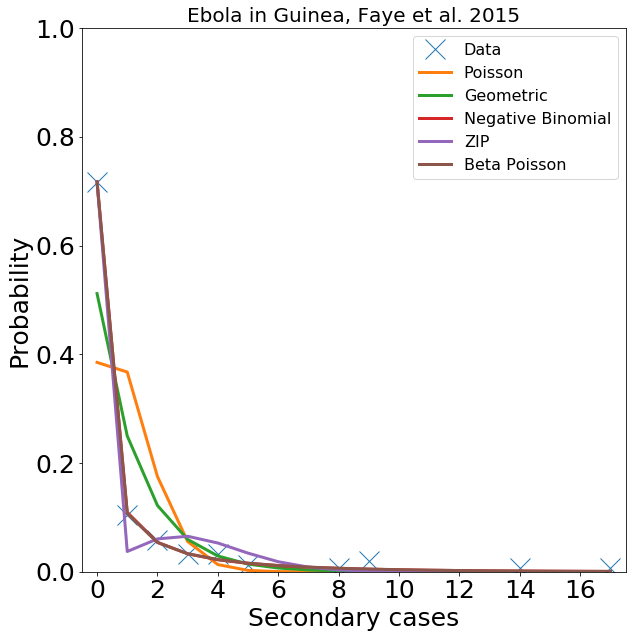

In [19]:
fig, ax=plt.subplots(figsize=(10,10))

xVals=range(max(current_data)+1)

counts,bins=np.histogram(current_data,np.max(current_data)+1)
dist=counts/len(current_data)
ax.plot(np.where(dist>0)[0],dist[dist>0],'x',markersize=20)
PoiLine=stats.poisson.pmf(xVals,np.mean(current_data))
ax.plot(xVals,PoiLine,lw=3)
GeomLine=stats.geom.pmf(xVals,1/(np.mean(current_data)+1),-1)
ax.plot(xVals,GeomLine,lw=3)
NegBinLine=stats.nbinom.pmf(xVals,np.mean(current_data)/theta_mle,1/(theta_mle+1))
ax.plot(xVals,NegBinLine,lw=3)
ZIPLine=zip_pmf(xVals,lmbd_mle,sigma_mle)
ax.plot(xVals,ZIPLine,lw=3)
BetaPoiLine=beta_poisson_pmf(xVals,np.mean(current_data),phi_mle,1/N_inv_mle)
ax.plot(xVals,BetaPoiLine,lw=3)
ax.axis([-0.5,np.max(current_data)+0.5,0,1])
ax.set_aspect((np.max(current_data)+1)/1)

ax.legend(['Data','Poisson','Geometric','Negative Binomial','ZIP','Beta Poisson'],fontsize=16)
plt.xlabel('Secondary cases',fontsize=25)
plt.ylabel('Probability',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Ebola in Guinea, Faye et al. 2015',fontsize=20)
plt.show()

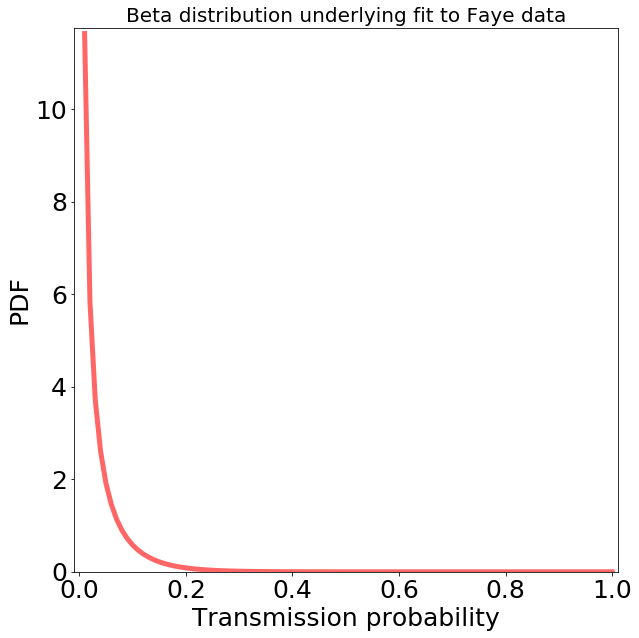

In [20]:
x = np.linspace(1e-2,1, 100)
y=stats.beta.pdf(x, np.mean(current_data)*phi_mle, (1/N_inv_mle-np.mean(current_data))*phi_mle)
fig,ax=plt.subplots(figsize=(10,10))
plt.plot(x, y,'r-', lw=5, alpha=0.6, label='beta pdf')
ax.axis([-0.01,1.01,0,1.01*np.max(y)])
ax.set_aspect(1.02/(1.01*np.max(y)))
plt.xlabel('Transmission probability',fontsize=25)
plt.ylabel('PDF',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Beta distribution underlying fit to Faye data',fontsize=20)
plt.show()

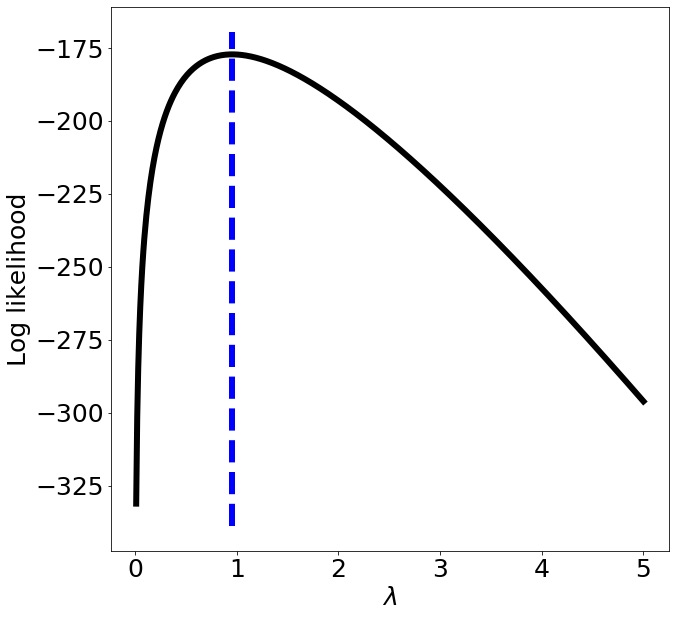

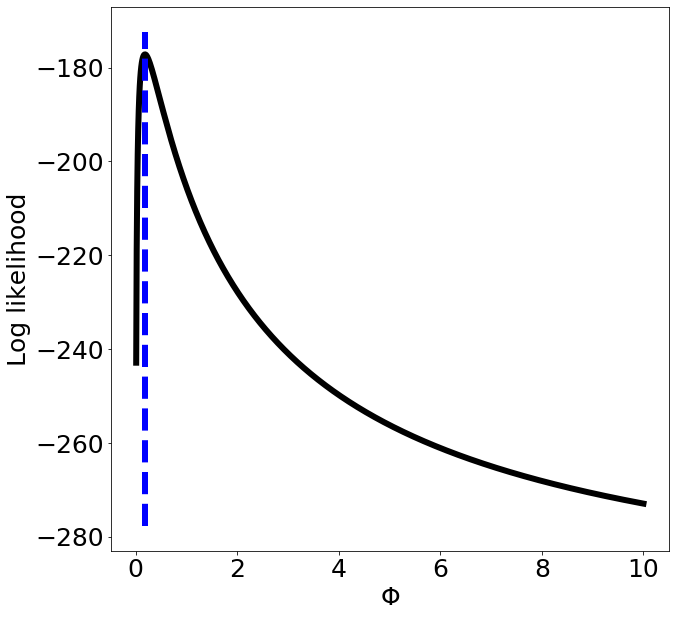

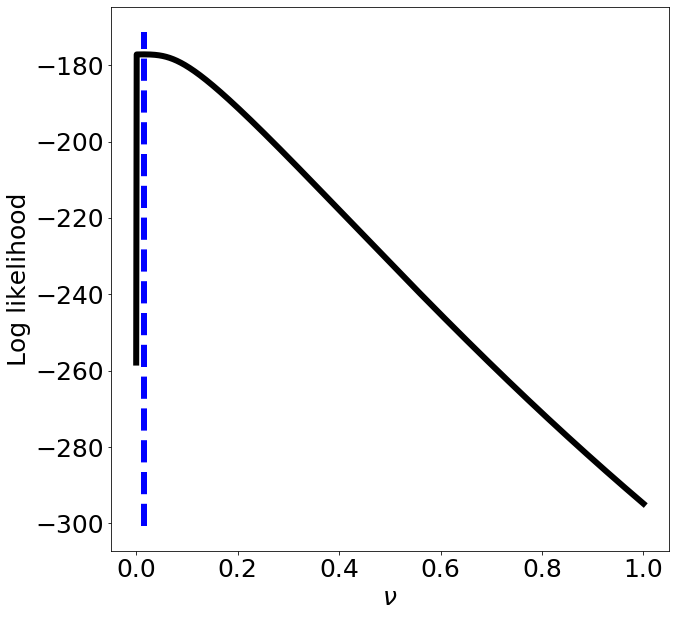

In [21]:
true_lmbd,true_phi,true_N=np.mean(current_data),phi_mle,1/N_inv_mle
data=current_data
lmbd_lh_array=beta_poisson_loglh(data,np.linspace(0.01,5,500),true_phi,true_N)
phi_lh_array=np.zeros(1000)
for i in range(1000):
    phi_lh_array[i]=beta_poisson_loglh(data,true_lmbd,(i+1)*1e-2,true_N)
n_lh_array=np.zeros(1001)
n_lh_array[0]=neg_bin_loglh(data,true_lmbd,true_phi)
for i in range(1,1001):
    n_lh_array[i]=beta_poisson_loglh(data,true_lmbd,true_phi,1/(i/1000))

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,5,500),lmbd_lh_array,'k',linewidth=6)
ax.plot([true_lmbd,true_lmbd],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,10,1000),phi_lh_array,'k',linewidth=6)
ax.plot([true_phi,true_phi],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\Phi$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.0,1,1001),n_lh_array,'k',linewidth=6)
ax.plot([1/true_N,1/true_N],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\\nu$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

**Ebola in Nigeria**

[Fasina et al. 2014](https://www.eurosurveillance.org/content/10.2807/1560-7917.ES2014.19.40.20920)

In [22]:
current_data=[0]*15+[1]*2+[2]+[3]+[12]
theta_mle=get_theta_mle(current_data,1.5)
phi_mle,N_inv_mle=get_phi_and_N_mles(current_data,0.5,1/50)
lmbd_mle,sigma_mle=get_zip_mles(current_data,1.5,0.5)

np.set_printoptions(precision=3)
print('Distribution          | Lambda | Theta | Sigma | Nu=1/N  |  Phi  | Log Likelihood |   AIC  |')
print('__________________________________________________________________________________________')
print('Poisson               |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% poisson_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*poisson_loglh(current_data,np.mean(current_data))))
print('Geometric             |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% geo_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*geo_loglh(current_data,np.mean(current_data))))
print('Negative binomial     |',"%.3f"% np.mean(current_data),' |',"%.3f"% theta_mle,'|       |         |       |   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),theta_mle),'    |',"%.3f"% (4-2*neg_bin_loglh(current_data,np.mean(current_data),theta_mle)))
print('Zero-inflated Poisson |',"%.3f"% lmbd_mle,' |       |',"%.3f"% sigma_mle,'|         |       |   ',"%.3f"% zip_loglh(current_data,lmbd_mle,sigma_mle),'    |',"%.3f"% (4-2*zip_loglh(current_data,lmbd_mle,sigma_mle)))
print('Beta Poisson          |',"%.3f"% np.mean(current_data),' |       |       | ',np.around(N_inv_mle,decimals=3),' |',"%.3f"% phi_mle,'|   ',"%.3f"% beta_poisson_loglh(current_data,np.mean(current_data),phi_mle,1/N_inv_mle),'    |',"%.3f"% (6-2*beta_poisson_loglh(current_data,np.mean(current_data),phi_mle,1/N_inv_mle)))

Distribution          | Lambda | Theta | Sigma | Nu=1/N  |  Phi  | Log Likelihood |   AIC  |
__________________________________________________________________________________________
Poisson               | 0.950  |       |       |         |       |    -42.447     | 86.893
Geometric             | 0.950  |       |       |         |       |    -27.020     | 56.040
Negative binomial     | 0.950  | 6.889 |       |         |       |    -21.727     | 47.454
Zero-inflated Poisson | 3.707  |       | 0.744 |         |       |    -27.235     | 58.471
Beta Poisson          | 0.950  |       |       |  0.047  | 0.123 |    -21.705     | 49.410


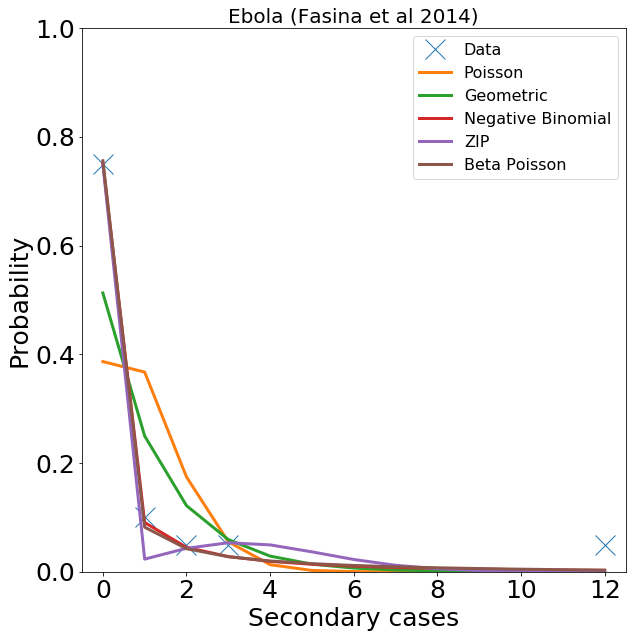

In [23]:
fig, ax=plt.subplots(figsize=(10,10))

xVals=range(max(current_data)+1)

counts,bins=np.histogram(current_data,np.max(current_data)+1)
dist=counts/len(current_data)
ax.plot(np.where(dist>0)[0],dist[dist>0],'x',markersize=20)
PoiLine=stats.poisson.pmf(xVals,np.mean(current_data))
ax.plot(xVals,PoiLine,lw=3)
GeomLine=stats.geom.pmf(xVals,1/(np.mean(current_data)+1),-1)
ax.plot(xVals,GeomLine,lw=3)
NegBinLine=stats.nbinom.pmf(xVals,np.mean(current_data)/theta_mle,1/(theta_mle+1))
ax.plot(xVals,NegBinLine,lw=3)
ZIPLine=zip_pmf(xVals,lmbd_mle,sigma_mle)
ax.plot(xVals,ZIPLine,lw=3)
BetaPoiLine=beta_poisson_pmf(xVals,np.mean(current_data),phi_mle,1/N_inv_mle)
ax.plot(xVals,BetaPoiLine,lw=3)
ax.axis([-0.5,np.max(current_data)+0.5,0,1])
ax.set_aspect((np.max(current_data)+1)/1)

ax.legend(['Data','Poisson','Geometric','Negative Binomial','ZIP','Beta Poisson'],fontsize=16)
plt.xlabel('Secondary cases',fontsize=25)
plt.ylabel('Probability',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Ebola (Fasina et al 2014)',fontsize=20)
plt.show()

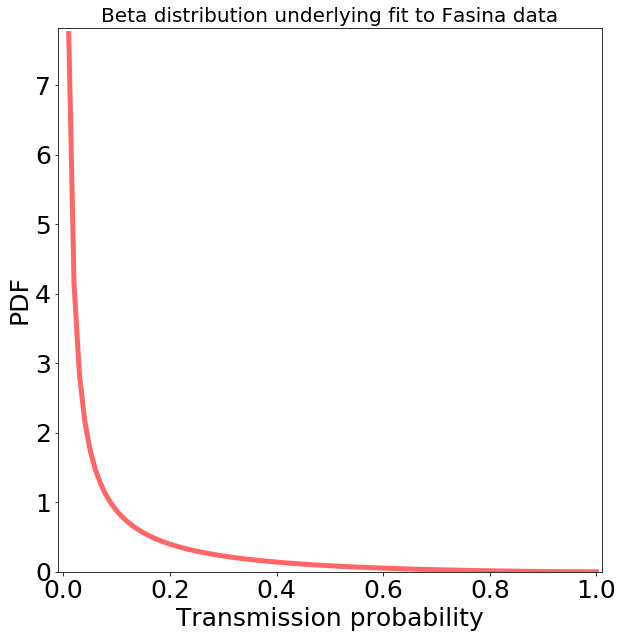

In [24]:
x = np.linspace(1e-2,1, 100)
y=stats.beta.pdf(x, np.mean(current_data)*phi_mle, (1/N_inv_mle-np.mean(current_data))*phi_mle)
fig,ax=plt.subplots(figsize=(10,10))
plt.plot(x, y,'r-', lw=5, alpha=0.6, label='beta pdf')
ax.axis([-0.01,1.01,0,1.01*np.max(y)])
ax.set_aspect(1.02/(1.01*np.max(y)))
plt.xlabel('Transmission probability',fontsize=25)
plt.ylabel('PDF',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Beta distribution underlying fit to Fasina data',fontsize=20)
plt.show()

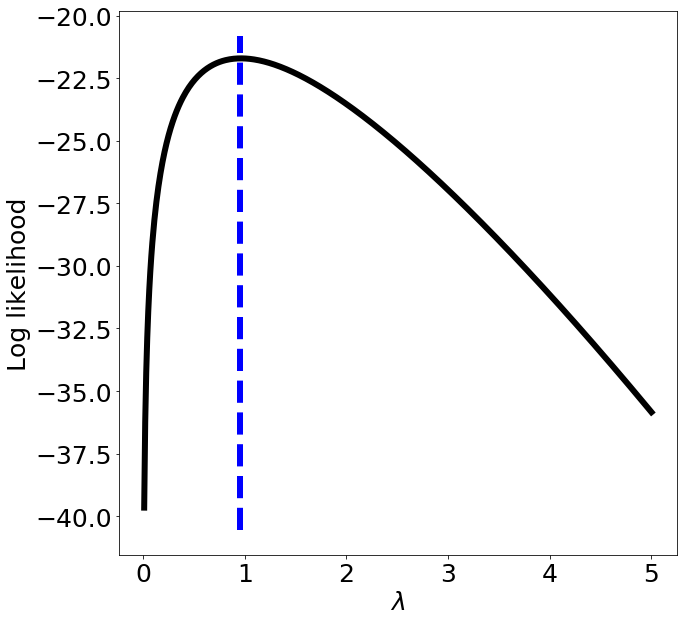

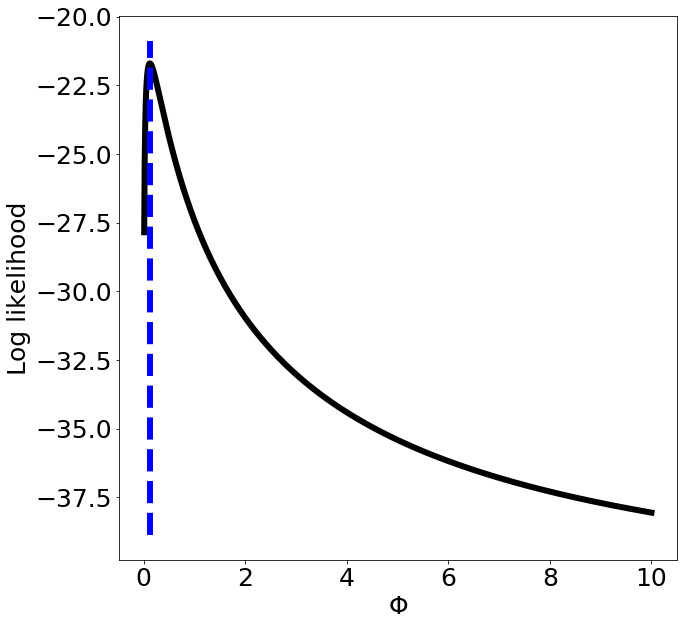

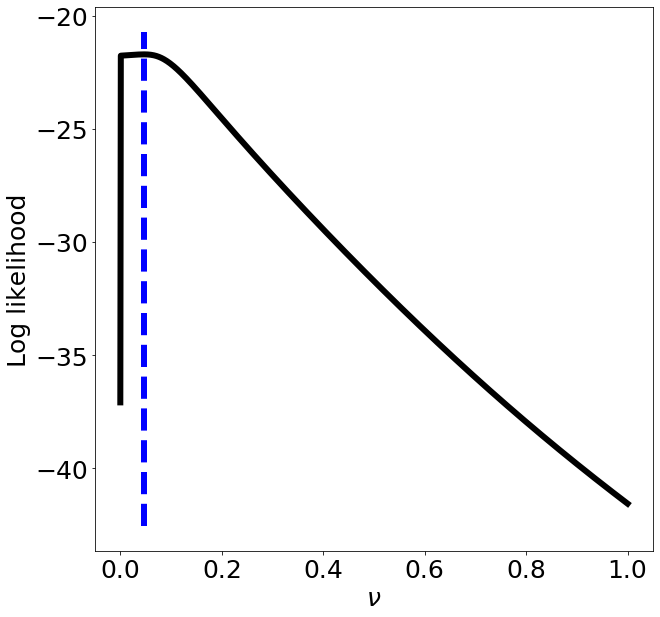

In [25]:
true_lmbd,true_phi,true_N=np.mean(current_data),phi_mle,1/N_inv_mle
data=current_data
lmbd_lh_array=beta_poisson_loglh(data,np.linspace(0.01,5,500),true_phi,true_N)
phi_lh_array=np.zeros(1000)
for i in range(1000):
    phi_lh_array[i]=beta_poisson_loglh(data,true_lmbd,(i+1)*1e-2,true_N)
n_lh_array=np.zeros(1001)
n_lh_array[0]=neg_bin_loglh(data,true_lmbd,true_phi)
for i in range(1,1001):
    n_lh_array[i]=beta_poisson_loglh(data,true_lmbd,true_phi,1/(i/1000))

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,5,500),lmbd_lh_array,'k',linewidth=6)
ax.plot([true_lmbd,true_lmbd],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,10,1000),phi_lh_array,'k',linewidth=6)
ax.plot([true_phi,true_phi],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\Phi$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.0,1,1001),n_lh_array,'k',linewidth=6)
ax.plot([1/true_N,1/true_N],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\\nu$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

**SARS in Singapore**

[Leo *et al.*](https://www.cdc.gov/mmwr/preview/mmwrhtml/mm5218a1.htm)

In [26]:
current_data=[0]*162+[1]*19+[2]*8+[3]*7+[7]+[12]+[21]+[23]+[40]

theta_mle=get_theta_mle(current_data,1.5)
phi_mle,N_inv_mle=get_phi_and_N_mles(current_data,0.5,1/2)
lmbd_mle,sigma_mle=get_zip_mles(np.asarray(current_data),1.5,0.5)

np.set_printoptions(precision=3)
print('Distribution          | Lambda | Theta | Sigma | Nu=1/N  |  Phi  | Log Likelihood |   AIC  |')
print('__________________________________________________________________________________________')
print('Poisson               |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% poisson_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*poisson_loglh(current_data,np.mean(current_data))))
print('Geometric             |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% geo_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*geo_loglh(current_data,np.mean(current_data))))
print('Negative binomial     |',"%.3f"% np.mean(current_data),' |',"%.3f"% theta_mle,'|       |         |       |   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),theta_mle),'    |',"%.3f"% (4-2*neg_bin_loglh(current_data,np.mean(current_data),theta_mle)))
print('Zero-inflated Poisson |',"%.3f"% lmbd_mle,' |       |',"%.3f"% sigma_mle,'|         |       |   ',"%.3f"% zip_loglh(current_data,lmbd_mle,sigma_mle),'    |',"%.3f"% (4-2*zip_loglh(current_data,lmbd_mle,sigma_mle)))
print('Beta Poisson          |',"%.3f"% np.mean(current_data),' |       |       |  ',np.around(N_inv_mle,decimals=3),'  |',"%.3f"% phi_mle,'|   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),1/phi_mle),'    |',"%.3f"% (6-2*neg_bin_loglh(current_data,np.mean(current_data),1/phi_mle)))

Distribution          | Lambda | Theta | Sigma | Nu=1/N  |  Phi  | Log Likelihood |   AIC  |
__________________________________________________________________________________________
Poisson               | 0.791  |       |       |         |       |    -450.177     | 902.354
Geometric             | 0.791  |       |       |         |       |    -247.077     | 496.155
Negative binomial     | 0.791  | 8.502 |       |         |       |    -176.733     | 357.466
Zero-inflated Poisson | 4.002  |       | 0.802 |         |       |    -287.660     | 579.321
Beta Poisson          | 0.791  |       |       |   0.0   | 0.118 |    -176.733     | 359.466


In this case the beta-Poisson model fits to its negative binomial extreme.

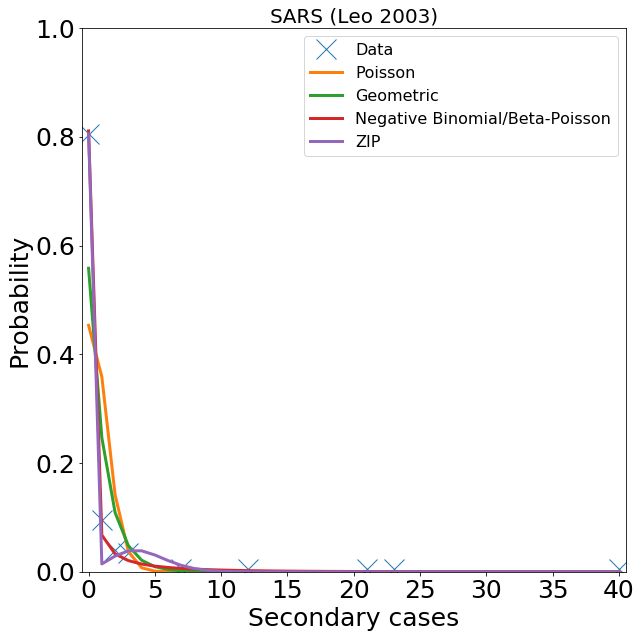

In [27]:
fig, ax=plt.subplots(figsize=(10,10))

xVals=range(max(current_data)+1)

counts,bins=np.histogram(current_data,np.max(current_data)+1)
dist=counts/len(current_data)
ax.plot(np.where(dist>0)[0],dist[dist>0],'x',markersize=20)
PoiLine=stats.poisson.pmf(xVals,np.mean(current_data))
ax.plot(xVals,PoiLine,lw=3)
GeomLine=stats.geom.pmf(xVals,1/(np.mean(current_data)+1),-1)
ax.plot(xVals,GeomLine,lw=3)
NegBinLine=stats.nbinom.pmf(xVals,np.mean(current_data)/theta_mle,1/(theta_mle+1))
ax.plot(xVals,NegBinLine,lw=3)
ZIPLine=zip_pmf(xVals,lmbd_mle,sigma_mle)
ax.plot(xVals,ZIPLine,lw=3)
ax.axis([-0.5,np.max(current_data)+0.5,0,1])
ax.set_aspect((np.max(current_data)+1)/1)

ax.legend(['Data','Poisson','Geometric','Negative Binomial/Beta-Poisson','ZIP'],fontsize=16)
plt.xlabel('Secondary cases',fontsize=25)
plt.ylabel('Probability',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('SARS (Leo 2003)',fontsize=20)
plt.show()

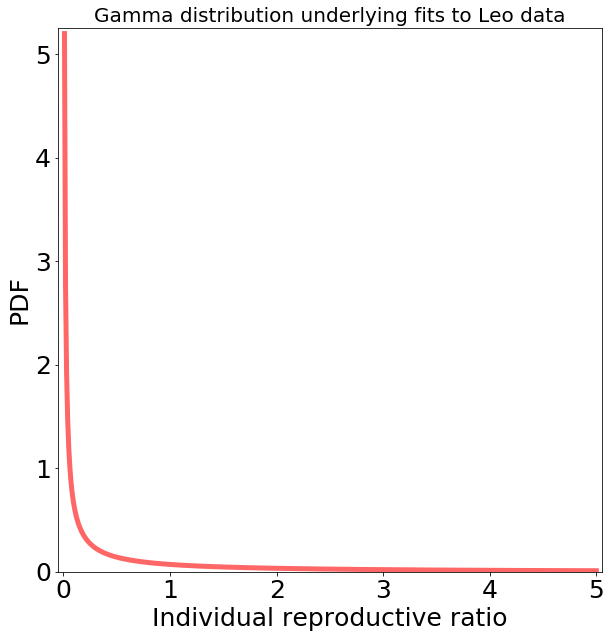

In [28]:
x = np.linspace(1e-2,5, 500)
y=stats.gamma.pdf(x, np.mean(current_data)/theta_mle, loc=0, scale=theta_mle)
fig,ax=plt.subplots(figsize=(10,10))
plt.plot(x, y,'r-', lw=5, alpha=0.6, label='beta pdf')
ax.axis([-0.05,5.05,0,1.01*np.max(y)])
ax.set_aspect(5.1/(1.01*np.max(y)))
plt.xlabel('Individual reproductive ratio',fontsize=25)
plt.ylabel('PDF',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Gamma distribution underlying fits to Leo data',fontsize=20)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


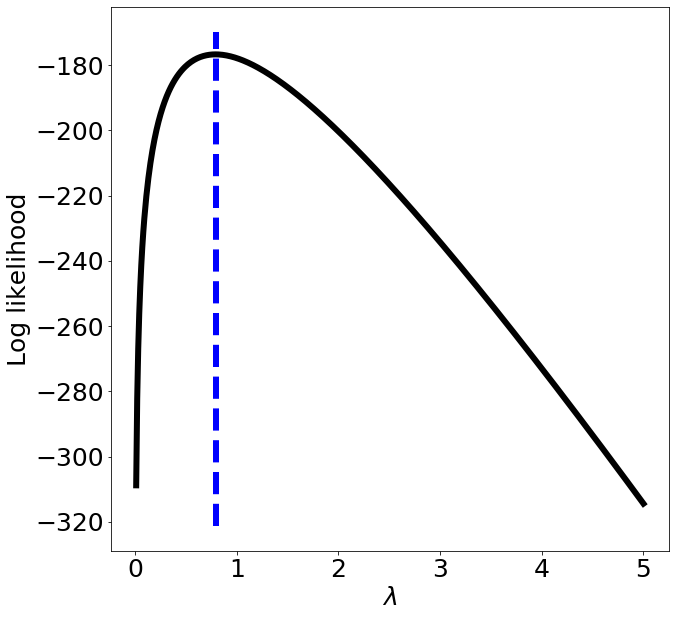

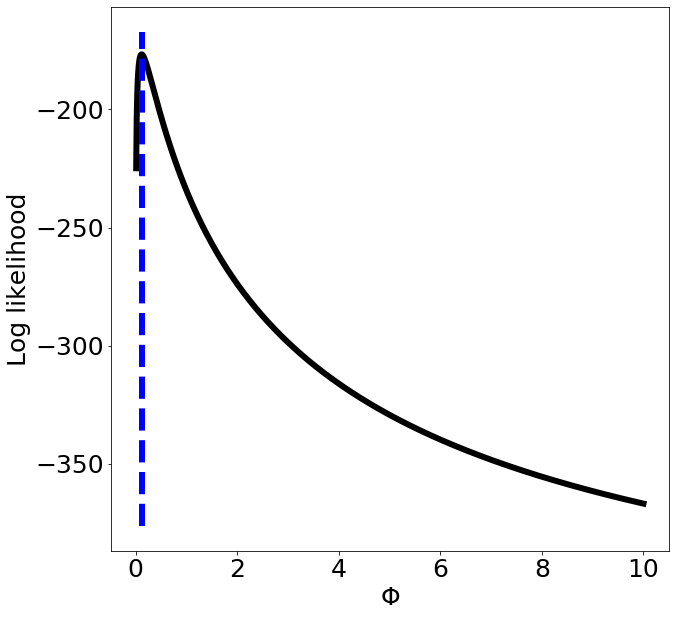

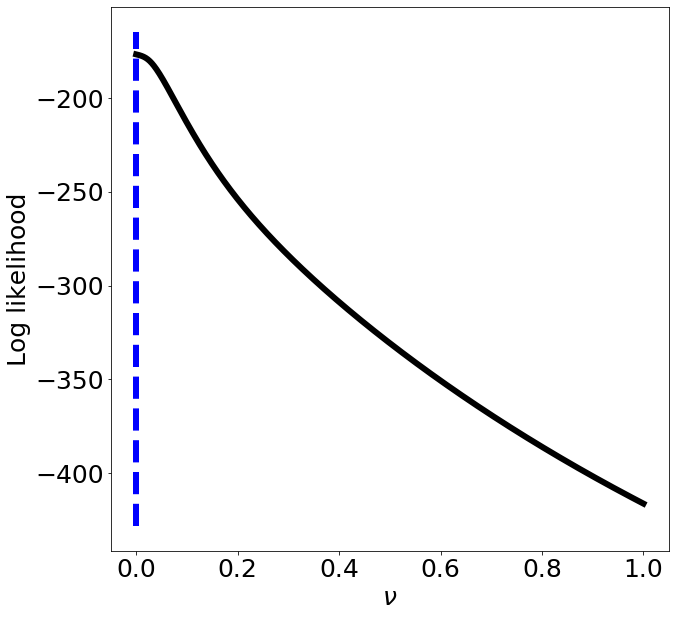

In [29]:
true_lmbd,true_phi,true_N=np.mean(current_data),phi_mle,1/N_inv_mle
data=current_data
lmbd_lh_array=neg_bin_bp_loglh(data,np.linspace(0.01,5,500),true_phi)
phi_lh_array=np.zeros(1000)
for i in range(1000):
    phi_lh_array[i]=neg_bin_bp_loglh(data,true_lmbd,(i+1)*1e-2)
n_lh_array=np.zeros(1001)
n_lh_array[0]=neg_bin_bp_loglh(data,true_lmbd,true_phi)
for i in range(1,1001):
    n_lh_array[i]=beta_poisson_loglh(data,true_lmbd,true_phi,1/(i/1000))

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,5,500),lmbd_lh_array,'k',linewidth=6)
ax.plot([true_lmbd,true_lmbd],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,10,1000),phi_lh_array,'k',linewidth=6)
ax.plot([true_phi,true_phi],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\Phi$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.0,1,1001),n_lh_array,'k',linewidth=6)
ax.plot([1/true_N,1/true_N],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\\nu$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

**MERS-Cov in South Korea**

[Cowling et. al. 2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4535930/)

In [30]:
current_data=[38,3,2,1,6,81,2,23,2,1,1,1,5,1,1,1,2,1,1,1]
current_data=current_data+[0]*(166-len(current_data))
theta_mle=get_theta_mle(current_data,1.5)
phi_mle,N_inv_mle=get_phi_and_N_mles(current_data,0.5,1/2)
lmbd_mle,sigma_mle=get_zip_mles(current_data,1.5,0.5)

np.set_printoptions(precision=3)
print('Distribution          | Lambda | Theta  | Sigma | Nu=1/N  |  Phi  | Log Likelihood |   AIC  |')
print('__________________________________________________________________________________________')
print('Poisson               |',"%.3f"% np.mean(current_data),' |        |       |         |       |   ',"%.3f"% poisson_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*poisson_loglh(current_data,np.mean(current_data))))
print('Geometric             |',"%.3f"% np.mean(current_data),' |        |       |         |       |   ',"%.3f"% geo_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*geo_loglh(current_data,np.mean(current_data))))
print('Negative binomial     |',"%.3f"% np.mean(current_data),' |',"%.3f"% theta_mle,'|       |         |       |   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),theta_mle),'    |',"%.3f"% (4-2*neg_bin_loglh(current_data,np.mean(current_data),theta_mle)))
print('Zero-inflated Poisson |',"%.3f"% lmbd_mle,' |        |',"%.3f"% sigma_mle,'|         |       |   ',"%.3f"% zip_loglh(current_data,lmbd_mle,sigma_mle),'    |',"%.3f"% (4-2*zip_loglh(current_data,lmbd_mle,sigma_mle)))
print('Beta Poisson          |',"%.3f"% np.mean(current_data),' |        |       |',np.around(N_inv_mle,decimals=3),'    |',"%.3f"% phi_mle,'|   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),1/phi_mle),'    |',"%.3f"% (6-2*neg_bin_loglh(current_data,np.mean(current_data),1/phi_mle)))

Distribution          | Lambda | Theta  | Sigma | Nu=1/N  |  Phi  | Log Likelihood |   AIC  |
__________________________________________________________________________________________
Poisson               | 1.048  |        |       |         |       |    -614.384     | 1230.768
Geometric             | 1.048  |        |       |         |       |    -235.576     | 473.152
Negative binomial     | 1.048  | 28.185 |       |         |       |    -110.332     | 224.664
Zero-inflated Poisson | 8.699  |        | 0.879 |         |       |    -307.221     | 618.442
Beta Poisson          | 1.048  |        |       | 0.0     | 0.035 |    -110.332     | 226.664


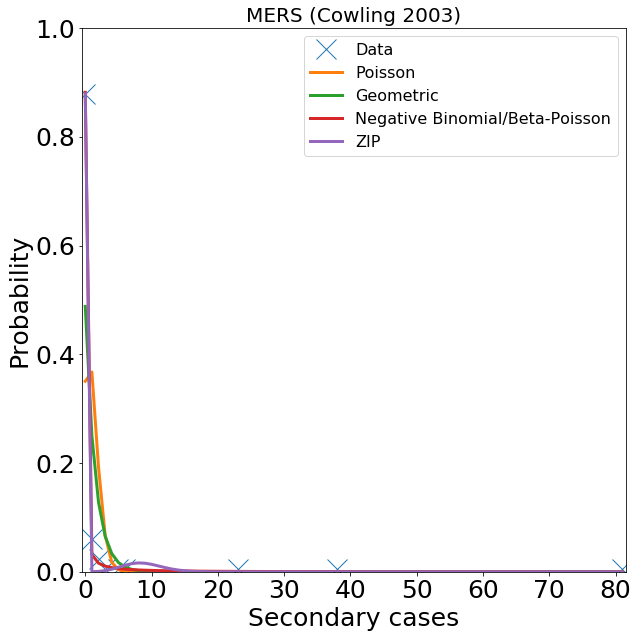

In [31]:
fig, ax=plt.subplots(figsize=(10,10))

xVals=range(max(current_data)+1)

counts,bins=np.histogram(current_data,np.max(current_data)+1)
dist=counts/len(current_data)
ax.plot(np.where(dist>0)[0],dist[dist>0],'x',markersize=20)
PoiLine=stats.poisson.pmf(xVals,np.mean(current_data))
ax.plot(xVals,PoiLine,lw=3)
GeomLine=stats.geom.pmf(xVals,1/(np.mean(current_data)+1),-1)
ax.plot(xVals,GeomLine,lw=3)
NegBinLine=stats.nbinom.pmf(xVals,np.mean(current_data)/theta_mle,1/(theta_mle+1))
ax.plot(xVals,NegBinLine,lw=3)
ZIPLine=zip_pmf(xVals,lmbd_mle,sigma_mle)
ax.plot(xVals,ZIPLine,lw=3)
ax.axis([-0.5,np.max(current_data)+0.5,0,1])
ax.set_aspect((np.max(current_data)+1)/1)

ax.legend(['Data','Poisson','Geometric','Negative Binomial/Beta-Poisson','ZIP'],fontsize=16)
plt.xlabel('Secondary cases',fontsize=25)
plt.ylabel('Probability',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('MERS (Cowling 2003)',fontsize=20)
plt.show()

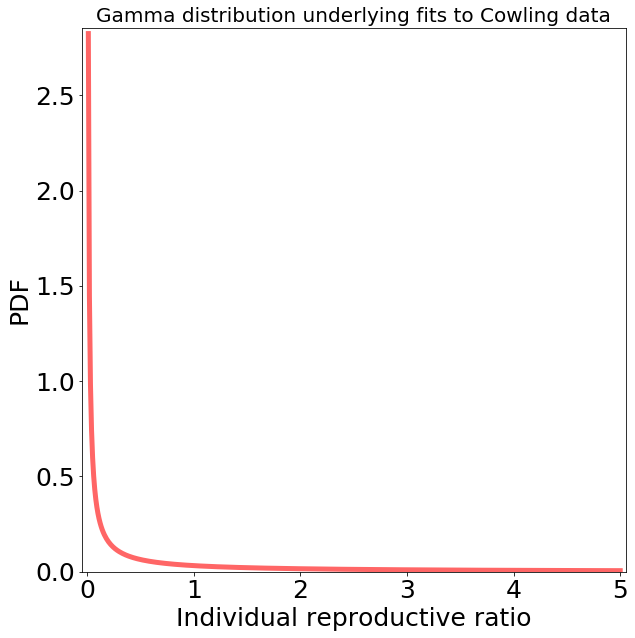

In [32]:
x = np.linspace(1e-2,5, 500)
y=stats.gamma.pdf(x, np.mean(current_data)/theta_mle, loc=0, scale=theta_mle)
fig,ax=plt.subplots(figsize=(10,10))
plt.plot(x, y,'r-', lw=5, alpha=0.6, label='beta pdf')
ax.axis([-0.05,5.05,0,1.01*np.max(y)])
ax.set_aspect(5.1/(1.01*np.max(y)))
plt.xlabel('Individual reproductive ratio',fontsize=25)
plt.ylabel('PDF',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Gamma distribution underlying fits to Cowling data',fontsize=20)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


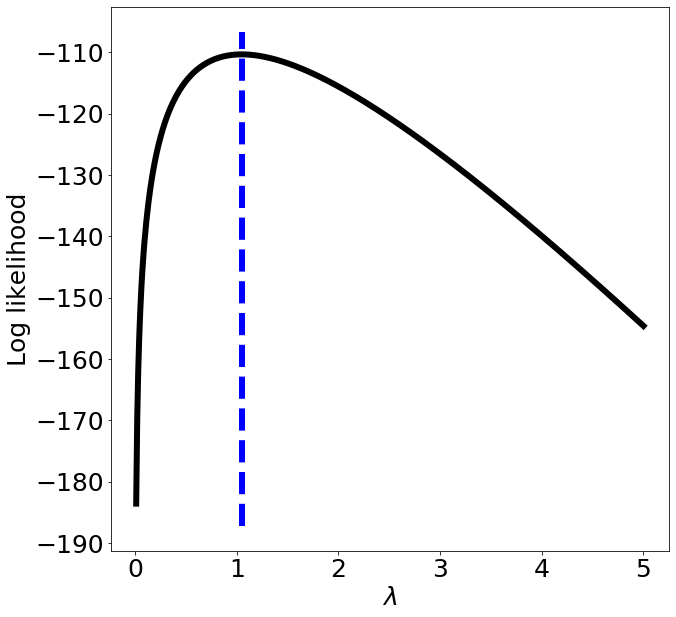

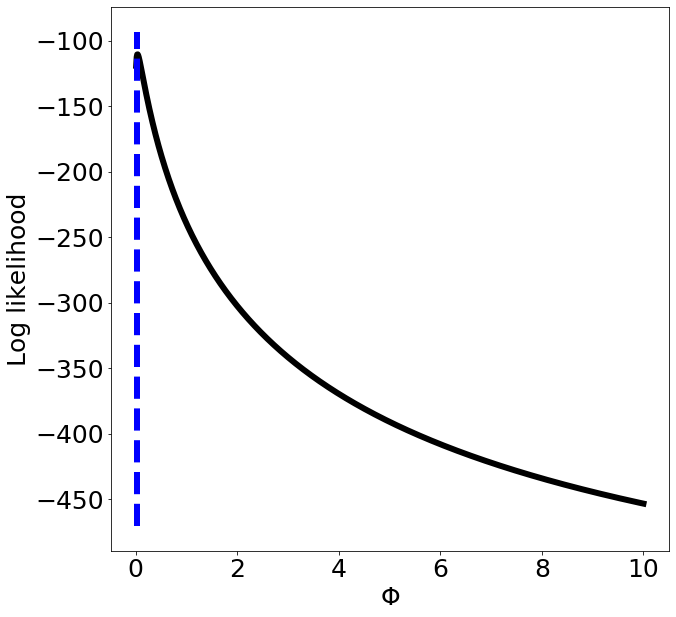

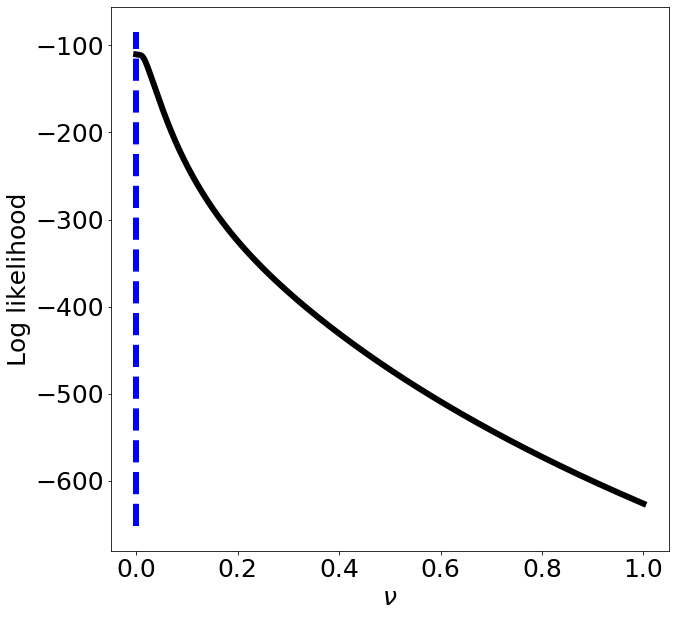

In [33]:
true_lmbd,true_phi,true_N=np.mean(current_data),phi_mle,1/N_inv_mle
data=current_data
lmbd_lh_array=neg_bin_bp_loglh(data,np.linspace(0.01,5,500),true_phi)
phi_lh_array=np.zeros(1000)
for i in range(1000):
    phi_lh_array[i]=neg_bin_bp_loglh(data,true_lmbd,(i+1)*1e-2)
n_lh_array=np.zeros(1001)
n_lh_array[0]=neg_bin_bp_loglh(data,true_lmbd,true_phi)
for i in range(1,1001):
    n_lh_array[i]=beta_poisson_loglh(data,true_lmbd,true_phi,1/(i/1000))

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,5,500),lmbd_lh_array,'k',linewidth=6)
ax.plot([true_lmbd,true_lmbd],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,10,1000),phi_lh_array,'k',linewidth=6)
ax.plot([true_phi,true_phi],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\Phi$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.0,1,1001),n_lh_array,'k',linewidth=6)
ax.plot([1/true_N,1/true_N],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\\nu$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

**MERS-CoV in Al-Has, Saudi Arabia**

[Chowell et al. 2015](https://bmcmedicine.biomedcentral.com/articles/10.1186/s12916-015-0450-0)

In [34]:
current_data=[0]*13+[1]*5+[2]*4+[3]+[7]
theta_mle=get_theta_mle(current_data,1.5)
phi_mle,N_inv_mle=get_phi_and_N_mles(current_data,0.5,1/2)
lmbd_mle,sigma_mle=get_zip_mles(current_data,1.5,0.5)

np.set_printoptions(precision=3)
print('Distribution          | Lambda | Theta  | Sigma | Nu=1/N  |  Phi  | Log Likelihood |   AIC  |')
print('__________________________________________________________________________________________')
print('Poisson               |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% poisson_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*poisson_loglh(current_data,np.mean(current_data))))
print('Geometric             |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% geo_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*geo_loglh(current_data,np.mean(current_data))))
print('Negative binomial     |',"%.3f"% np.mean(current_data),' |',"%.3f"% theta_mle,'|       |         |       |   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),theta_mle),'    |',"%.3f"% (4-2*neg_bin_loglh(current_data,np.mean(current_data),theta_mle)))
print('Zero-inflated Poisson |',"%.3f"% lmbd_mle,' |       |',"%.3f"% sigma_mle,'|         |       |   ',"%.3f"% zip_loglh(current_data,lmbd_mle,sigma_mle),'    |',"%.3f"% (4-2*zip_loglh(current_data,lmbd_mle,sigma_mle)))
print('Beta Poisson          |',"%.3f"% np.mean(current_data),' |       |       |',np.around(N_inv_mle,decimals=3),'    |',"%.3f"% phi_mle,'|   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),1/phi_mle),'    |',"%.3f"% (6-2*neg_bin_loglh(current_data,np.mean(current_data),1/phi_mle)))

Distribution          | Lambda | Theta  | Sigma | Nu=1/N  |  Phi  | Log Likelihood |   AIC  |
__________________________________________________________________________________________
Poisson               | 0.958  |       |       |         |       |    -37.068     | 76.137
Geometric             | 0.958  |       |       |         |       |    -32.567     | 67.135
Negative binomial     | 0.958  | 1.333 |       |         |       |    -32.446     | 68.891
Zero-inflated Poisson | 1.714  |       | 0.441 |         |       |    -33.918     | 71.835
Beta Poisson          | 0.958  |       |       | 0.0     | 0.750 |    -32.446     | 70.891


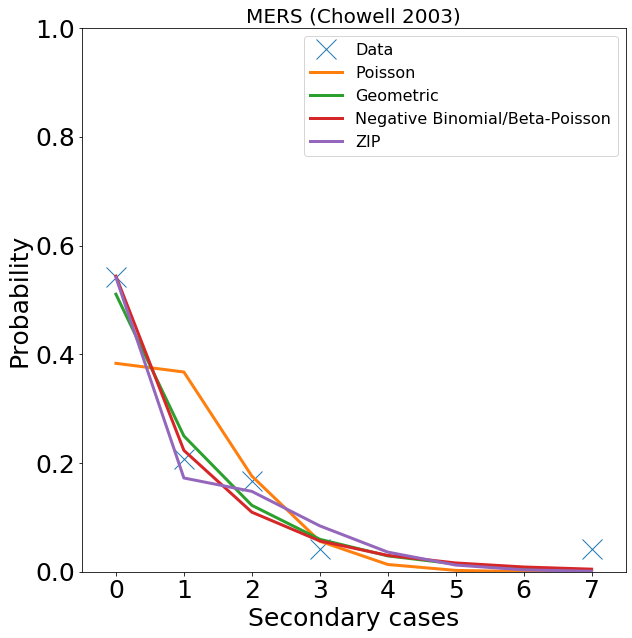

In [35]:
fig, ax=plt.subplots(figsize=(10,10))

xVals=range(max(current_data)+1)

counts,bins=np.histogram(current_data,np.max(current_data)+1)
dist=counts/len(current_data)
ax.plot(np.where(dist>0)[0],dist[dist>0],'x',markersize=20)
PoiLine=stats.poisson.pmf(xVals,np.mean(current_data))
ax.plot(xVals,PoiLine,lw=3)
GeomLine=stats.geom.pmf(xVals,1/(np.mean(current_data)+1),-1)
ax.plot(xVals,GeomLine,lw=3)
NegBinLine=stats.nbinom.pmf(xVals,np.mean(current_data)/theta_mle,1/(theta_mle+1))
ax.plot(xVals,NegBinLine,lw=3)
ZIPLine=zip_pmf(xVals,lmbd_mle,sigma_mle)
ax.plot(xVals,ZIPLine,lw=3)
ax.axis([-0.5,np.max(current_data)+0.5,0,1])
ax.set_aspect((np.max(current_data)+1)/1)

ax.legend(['Data','Poisson','Geometric','Negative Binomial/Beta-Poisson','ZIP'],fontsize=16)
plt.xlabel('Secondary cases',fontsize=25)
plt.ylabel('Probability',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('MERS (Chowell 2003)',fontsize=20)
plt.show()

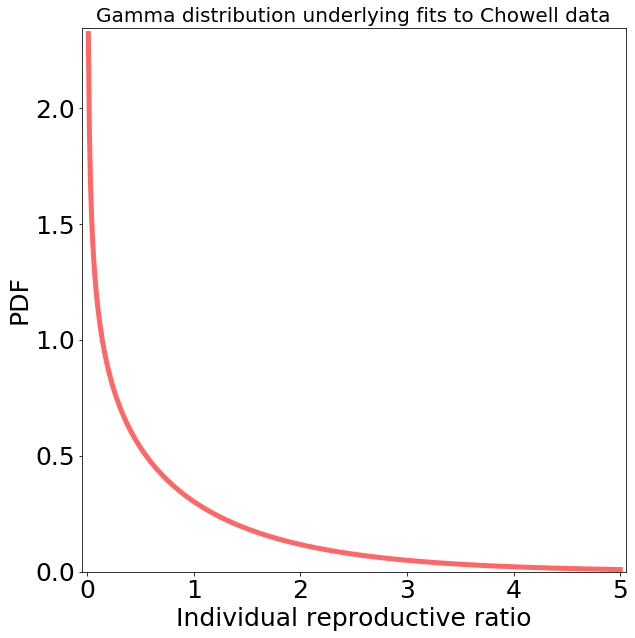

In [36]:
x = np.linspace(1e-2,5, 500)
y=stats.gamma.pdf(x, np.mean(current_data)/theta_mle, loc=0, scale=theta_mle)
fig,ax=plt.subplots(figsize=(10,10))
plt.plot(x, y,'r-', lw=5, alpha=0.6, label='beta pdf')
ax.axis([-0.05,5.05,0,1.01*np.max(y)])
ax.set_aspect(5.1/(1.01*np.max(y)))
plt.xlabel('Individual reproductive ratio',fontsize=25)
plt.ylabel('PDF',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Gamma distribution underlying fits to Chowell data',fontsize=20)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


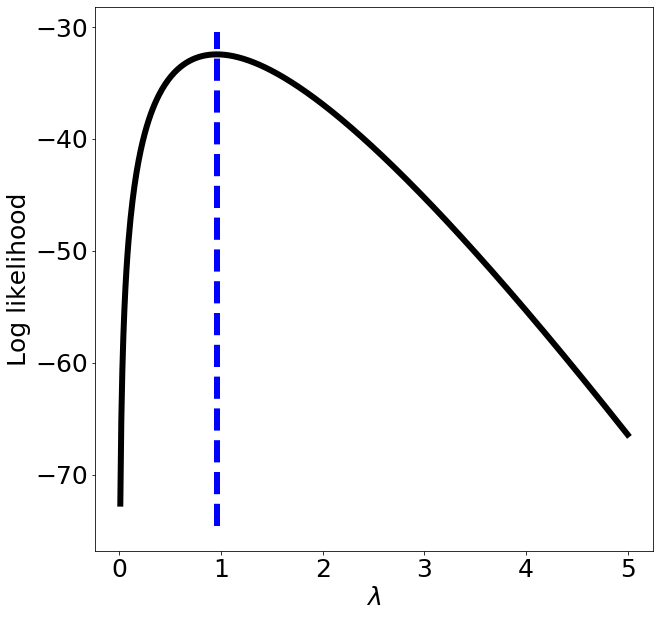

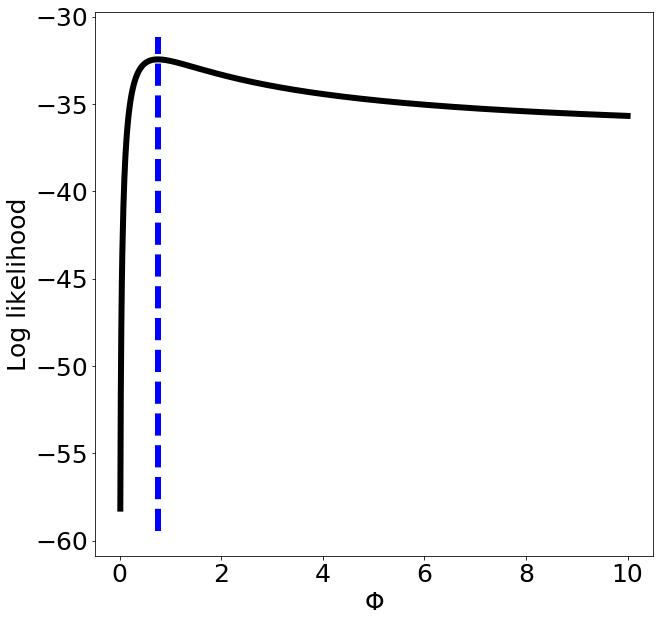

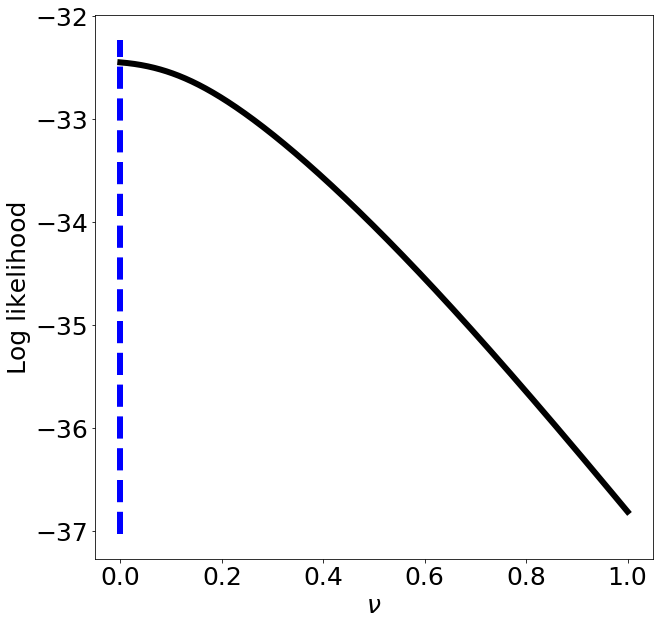

In [37]:
true_lmbd,true_phi,true_N=np.mean(current_data),phi_mle,1/N_inv_mle
data=current_data
lmbd_lh_array=neg_bin_bp_loglh(data,np.linspace(0.01,5,500),true_phi)
phi_lh_array=np.zeros(1000)
for i in range(1000):
    phi_lh_array[i]=neg_bin_bp_loglh(data,true_lmbd,(i+1)*1e-2)
n_lh_array=np.zeros(1001)
n_lh_array[0]=neg_bin_bp_loglh(data,true_lmbd,true_phi)
for i in range(1,1001):
    n_lh_array[i]=beta_poisson_loglh(data,true_lmbd,true_phi,1/(i/1000))

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,5,500),lmbd_lh_array,'k',linewidth=6)
ax.plot([true_lmbd,true_lmbd],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,10,1000),phi_lh_array,'k',linewidth=6)
ax.plot([true_phi,true_phi],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\Phi$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.0,1,1001),n_lh_array,'k',linewidth=6)
ax.plot([1/true_N,1/true_N],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\\nu$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

**Norovirus in the Netherlands**

[Heijne et al.](https://journals.lww.com/epidem/fulltext/2012/03000/Quantifying_Transmission_of_Norovirus_During_an.16.aspx)

In [38]:
current_data=[0]*22+[1]*13+[2]*6+[3]*3+[4]+[5]

theta_mle=get_theta_mle(current_data,1.5)
phi_mle,N_inv_mle=get_phi_and_N_mles(current_data,0.5,1/3)
lmbd_mle,sigma_mle=get_zip_mles(current_data,1.5,0.5)

np.set_printoptions(precision=3)
print('Distribution          | Lambda | Theta | Sigma | Nu=1/N  |  Phi  | Log Likelihood  |   AIC  |')
print('__________________________________________________________________________________________')
print('Poisson               |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% poisson_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*poisson_loglh(current_data,np.mean(current_data))))
print('Geometric             |',"%.3f"% np.mean(current_data),' |       |       |         |       |   ',"%.3f"% geo_loglh(current_data,np.mean(current_data)),'    |',"%.3f"% (2-2*geo_loglh(current_data,np.mean(current_data))))
print('Negative binomial     |',"%.3f"% np.mean(current_data),' |',"%.3f"% theta_mle,'|       |         |       |   ',"%.3f"% neg_bin_loglh(current_data,np.mean(current_data),theta_mle),'    |',"%.3f"% (4-2*neg_bin_loglh(current_data,np.mean(current_data),theta_mle)))
print('Zero-inflated Poisson |',"%.3f"% lmbd_mle,' |       |',"%.3f"% sigma_mle,'|         |       |   ',"%.3f"% zip_loglh(current_data,lmbd_mle,sigma_mle),'    |',"%.3f"% (4-2*zip_loglh(current_data,lmbd_mle,sigma_mle)))
print('Beta Poisson          |',"%.3f"% np.mean(current_data),' |       |       | ',np.around(N_inv_mle,decimals=3),' |',"%.3f"% phi_mle,'|   ',"%.3f"% beta_poisson_loglh(current_data,np.mean(current_data),phi_mle,1/N_inv_mle),'    |',"%.3f"% (6-2*beta_poisson_loglh(current_data,np.mean(current_data),phi_mle,1/N_inv_mle)))

Distribution          | Lambda | Theta | Sigma | Nu=1/N  |  Phi  | Log Likelihood  |   AIC  |
__________________________________________________________________________________________
Poisson               | 0.935  |       |       |         |       |    -63.400     | 128.799
Geometric             | 0.935  |       |       |         |       |    -61.640     | 125.279
Negative binomial     | 0.935  | 0.555 |       |         |       |    -61.285     | 126.570
Zero-inflated Poisson | 1.307  |       | 0.285 |         |       |    -61.623     | 127.245
Beta Poisson          | 0.935  |       |       |  0.308  | 1.074 |    -61.230     | 128.461


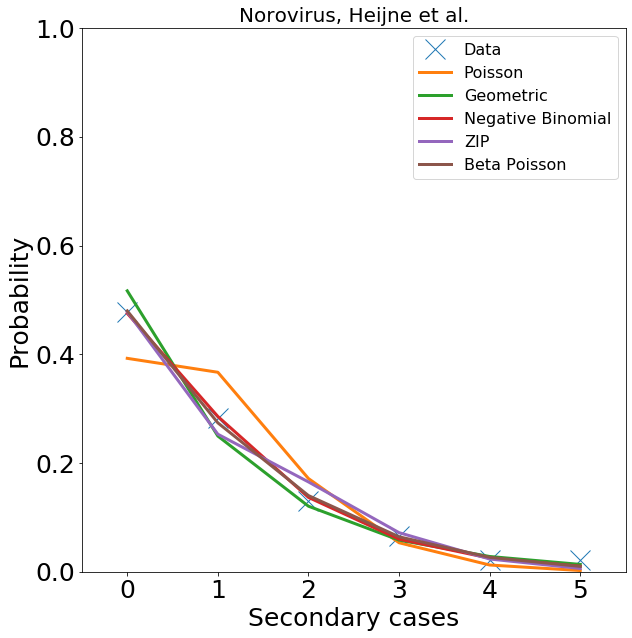

In [39]:
fig, ax=plt.subplots(figsize=(10,10))

xVals=range(max(current_data)+1)

counts,bins=np.histogram(current_data,np.max(current_data)+1)
dist=counts/len(current_data)
ax.plot(np.where(dist>0)[0],dist[dist>0],'x',markersize=20)
PoiLine=stats.poisson.pmf(xVals,np.mean(current_data))
ax.plot(xVals,PoiLine,lw=3)
GeomLine=stats.geom.pmf(xVals,1/(np.mean(current_data)+1),-1)
ax.plot(xVals,GeomLine,lw=3)
NegBinLine=stats.nbinom.pmf(xVals,np.mean(current_data)/theta_mle,1/(theta_mle+1))
ax.plot(xVals,NegBinLine,lw=3)
ZIPLine=zip_pmf(xVals,lmbd_mle,sigma_mle)
ax.plot(xVals,ZIPLine,lw=3)
BetaPoiLine=beta_poisson_pmf(xVals,np.mean(current_data),phi_mle,1/N_inv_mle)
ax.plot(xVals,BetaPoiLine,lw=3)
ax.axis([-0.5,np.max(current_data)+0.5,0,1])
ax.set_aspect((np.max(current_data)+1)/1)

ax.legend(['Data','Poisson','Geometric','Negative Binomial','ZIP','Beta Poisson'],fontsize=16)
plt.xlabel('Secondary cases',fontsize=25)
plt.ylabel('Probability',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Norovirus, Heijne et al.',fontsize=20)
plt.show()

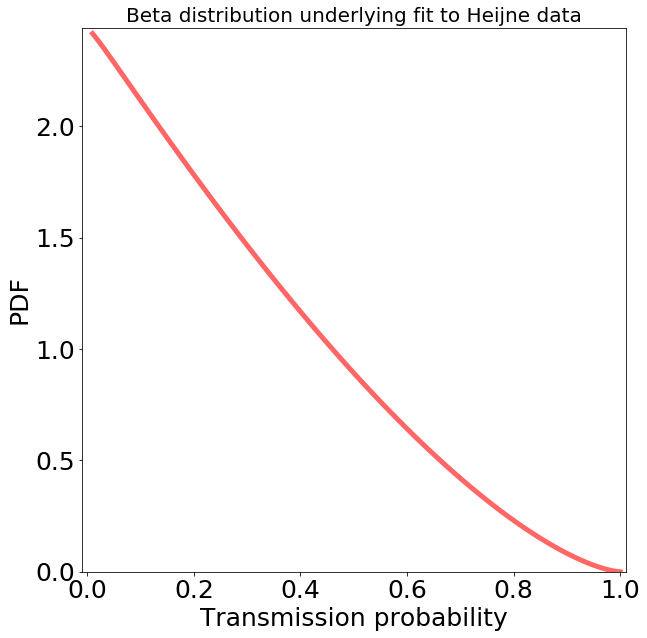

In [40]:
x = np.linspace(1e-2,1, 100)
y=stats.beta.pdf(x, np.mean(current_data)*phi_mle, (1/N_inv_mle-np.mean(current_data))*phi_mle)
fig,ax=plt.subplots(figsize=(10,10))
plt.plot(x, y,'r-', lw=5, alpha=0.6, label='beta pdf')
ax.axis([-0.01,1.01,0,1.01*np.max(y)])
ax.set_aspect(1.02/(1.01*np.max(y)))
plt.xlabel('Transmission probability',fontsize=25)
plt.ylabel('PDF',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Beta distribution underlying fit to Heijne data',fontsize=20)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


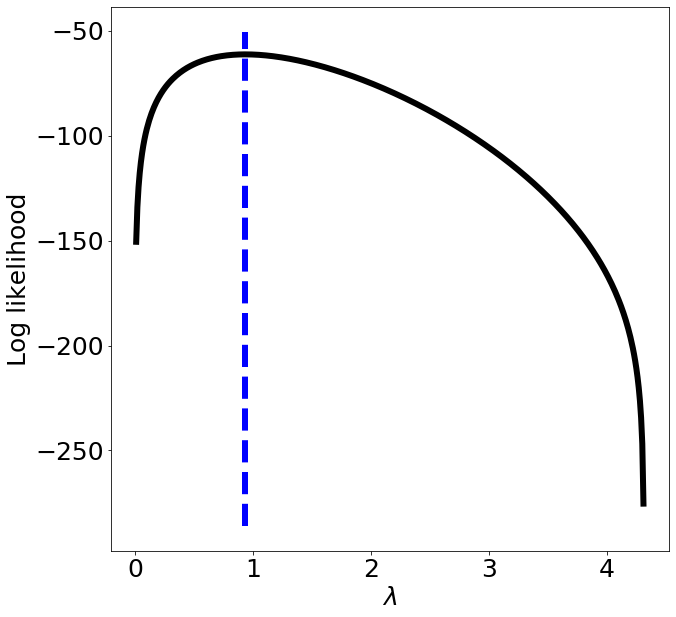

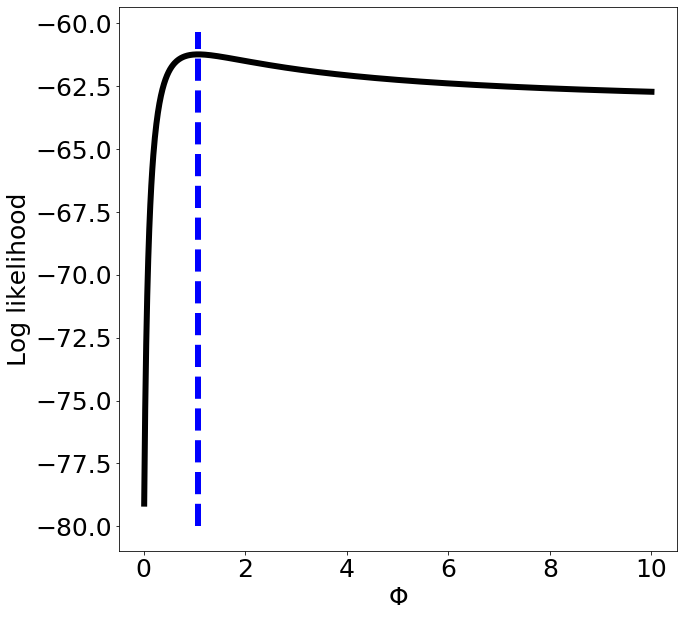

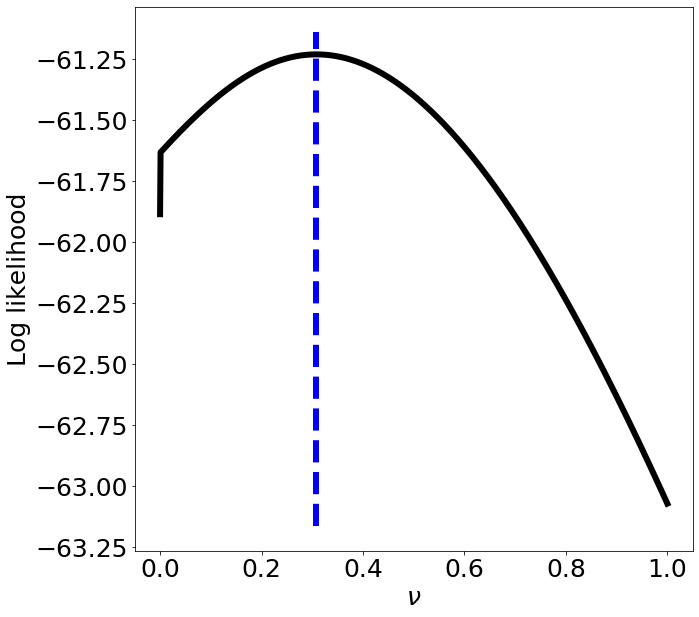

In [41]:
true_lmbd,true_phi,true_N=np.mean(current_data),phi_mle,1/N_inv_mle
data=current_data
lmbd_lh_array=beta_poisson_loglh(data,np.linspace(0.01,5,500),true_phi,true_N)
phi_lh_array=np.zeros(1000)
for i in range(1000):
    phi_lh_array[i]=beta_poisson_loglh(data,true_lmbd,(i+1)*1e-2,true_N)
n_lh_array=np.zeros(1001)
n_lh_array[0]=neg_bin_loglh(data,true_lmbd,true_phi)
for i in range(1,1001):
    n_lh_array[i]=beta_poisson_loglh(data,true_lmbd,true_phi,1/(i/1000))

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,5,500),lmbd_lh_array,'k',linewidth=6)
ax.plot([true_lmbd,true_lmbd],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\lambda$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.01,10,1000),phi_lh_array,'k',linewidth=6)
ax.plot([true_phi,true_phi],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\Phi$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

fig,ax=plt.subplots(figsize=(10,10))
ax.plot(np.linspace(0.0,1,1001),n_lh_array,'k',linewidth=6)
ax.plot([1/true_N,1/true_N],ax.get_ylim(),'--b',linewidth=6)
plt.xlabel('$\\nu$',fontsize=25)
plt.ylabel('Log likelihood',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()